<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/Consolidated_GEFS_ML_Max_Temp_Min_Temp_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import requests
import zipfile
import io

# GitHub raw URL for the file at a specific commit.
url = "https://github.com/m-wessler/gefs-ai-ml/raw/3beeb05561e7ce983dd67c0c40a89318a6baa560/testfiles.zip"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    # Load the content into a BytesIO object
    zip_bytes = io.BytesIO(response.content)
    # Open the ZIP file without saving to disk
    with zipfile.ZipFile(zip_bytes) as z:
        z.extractall("")
    print("Downloaded and extracted testfiles.zip to 'testfiles_unzipped' directory")
else:
    print(f"Failed to download file: HTTP {response.status_code}")

Downloaded and extracted testfiles.zip to 'testfiles_unzipped' directory


In [62]:
# Imports: Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
import glob
import warnings
import base64
from io import BytesIO
warnings.filterwarnings('ignore')

# Imports: Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import various model types
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm

# Import for HTML display
from IPython.display import display, HTML, clear_output

# Optional: GPU Support Check
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    GPU = True
else:
    print("PyTorch not available")
    GPU = None

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ==============================
# CONFIGURATION SECTION
# ==============================

# Data Configuration
CONFIG = {
    # Data Settings
    'data_dir': '/content/',                          # Directory containing the data files
    'station_ids': ['KBOI'],                          # List of station IDs to process
    'forecast_hours': ['024'],                        # List of forecast hours to process
    'file_pattern': '{stid}_2000_2009_f{fhr}.csv',    # Pattern for filenames
    'target_variable': 'tmax_obs',                    # Target variable to predict

    # Cross-Model Evaluation Settings
    'external_data_enabled': True,                    # Enable cross-model evaluation
    'external_file_pattern': '{stid}_2023_2023_f{fhr}.csv',  # Pattern for external files

    # Benchmark Comparison Settings
    'benchmark_enabled': True,                        # Enable comparison with benchmark model
    'benchmark_file_pattern': '{stid}_2023_2024_f{fhr}.csv',  # Pattern for NBM benchmark files
    'benchmark_forecast_var': 'tmax_2m',              # Variable containing benchmark forecasts

    # Feature Selection Settings
    'base_exclude_vars': ['sid', 'state', 'init_datetime', 'fcst_hour',
                          'perturbation', 'tmin_obs', 'tmin_2m',
                          'tmax_2m', 't2m'

                          # Also exclude (for now) variables we haven't downloaded yet (bfile, sfile)
                          'spfh_pres_925', 'spfh_pres_850', 'spfh_pres_700', 'gflux_sfc',
                          'cape_sfc', 'hgt_ceiling', 'vflx_sfc', 'gust_sfc', 'cin_sfc',
                          'uflx_sfc', 'spfh_2m',

                          # Experimenting/Add-One-In
                        #   'hgt_sfc', 'elev_ft', 'pres_msl', 'pres_sfc', 'hgt_pres_925',
                        #   'hgt_pres_850',  'tmp_2m', 'tmp_pres_925',
                        #   'tmp_pres_850', 'spfh_pres_925', 'ugrd_hgt',
                        #   'ugrd_pres_925', 'ugrd_pres_850',  'vgrd_hgt',
                        #   'vgrd_pres_925', 'vgrd_pres_850',  'dswrf_sfc',
                        #   'dlwrf_sfc', 'uswrf_sfc', 'ulwrf_sfc', 'lhtfl_sfc', 'shtfl_sfc',
                        #   'soilw_bgrnd', 'tcdc_eatm', 'doy'

                        #   'tmp_pres_700','hgt_pres_700','ugrd_pres_700','vgrd_pres_700',
                          ],
    'numeric_only': True,                             # Filter to keep only numeric columns

    # Model Settings
    'model_type': 'xgboost',                          # Options: 'linear', 'ridge', 'lasso',
                                                      # 'elasticnet', 'rf', 'gbm', 'xgboost',
                                                      # 'lightgbm'
    'model_params': {                                 # Model-specific parameters
        'xgboost': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'gpu_hist' if GPU else None,
            'random_state': RANDOM_STATE,
            'early_stopping_rounds':20,
        },
        'lightgbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE
        },
        'rf': {
            'n_estimators': 200,
            'max_depth': 10,
            'min_samples_split': 5,
            'random_state': RANDOM_STATE
        },
        'linear': {},
        'ridge': {'alpha': 1.0},
        'lasso': {'alpha': 0.1},
        'elasticnet': {'alpha': 0.1, 'l1_ratio': 0.5},
        'gbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'random_state': RANDOM_STATE
        },
    },

    # Training Settings
    'holdout_size': 0.1,                              # Proportion of data for hold-out verification
    'test_size': 0.2,                                 # Proportion of remaining data for testing
    'val_size': 0.2,                                  # Proportion of training data for validation
    'cv_folds': 5,                                    # Number of cross-validation folds

    # Preprocessing Settings
    'add_day_of_year': True,                          # Add day-of-year feature
    'standardize_features': False,                    # Standardize features
    'handle_missing': True,                           # Handle missing values

    # Visualization Settings
    'show_feature_importance': True,                  # Show feature importance plot
    'show_scatter_plot': True,                        # Show scatter plot of predictions
    'show_residual_plot': True,                       # Show residual plot
    'show_distribution_plot': True,                   # Show distribution of predictions vs actual
    'show_error_by_feature': True,                    # Show error distribution by key features
    'show_benchmark_comparison': True,                # Show comparison with benchmark model
    'top_n_features': 10,                             # Number of top features to display
    'show_cross_model_comparison': True,              # Show comparison of model performance across datasets
    'use_tabs_for_plots': True,                       # Use tabbed interface for plots
    'fig_width': 10,                                  # Default figure width in inches
    'fig_height': 6,                                  # Default figure height in inches
    'fig_scale': 80                                   # Figure scale as percentage (80 = 80%)
}

# ==============================
# DATA LOADING & PREPROCESSING
# ==============================

def filter_numeric_columns(df, target_variable):
    """Filter dataframe to keep only numeric columns and the target variable"""
    # Ensure target variable is kept regardless of type
    all_columns = df.columns.tolist()
    non_target_columns = [col for col in all_columns if col != target_variable]

    # Select numeric columns from non-target columns
    numeric_columns = df[non_target_columns].select_dtypes(include=['number']).columns.tolist()

    # Add target variable back
    if target_variable in all_columns:
        columns_to_keep = numeric_columns + [target_variable]
    else:
        columns_to_keep = numeric_columns

    # Filter the dataframe
    df_numeric = df[columns_to_keep]

    # Report columns dropped
    dropped_columns = [col for col in all_columns if col not in columns_to_keep]
    if dropped_columns:
        print(f"Dropped {len(dropped_columns)} non-numeric columns: {dropped_columns}")

    return df_numeric

def load_data(config, file_pattern=None, is_external=False, is_benchmark=False):
    """Load and prepare the dataset based on configuration, handling multiple stations and forecast hours"""
    if is_benchmark:
        data_source = "NBM Benchmark"
    elif is_external:
        data_source = "External GEFS Forecast"
    else:
        data_source = "GEFS Reforecast"

    print(f"Loading {data_source} data for {len(config['station_ids'])} station(s) and {len(config['forecast_hours'])} forecast hour(s)...")

    # Use provided file pattern or default from config
    if file_pattern is None:
        file_pattern = config['file_pattern']

    # Determine if we're using single or multiple stations
    is_single_station = len(config['station_ids']) == 1

    # Define which variables to exclude based on station count
    exclude_vars = config['base_exclude_vars'].copy()

    # For single station, exclude elevation and surface height as they're constant
    if is_single_station and not is_benchmark:
        exclude_vars.extend(['hgt_sfc', 'elev_ft'])
        print("Single station mode: 'hgt_sfc' and 'elev_ft' will be excluded as features")
    else:
        print("Multi-station mode: 'hgt_sfc' and 'elev_ft' will be included as features")

    # Create list to hold all dataframes
    all_dfs = []

    # Loop through all combinations of station IDs and forecast hours
    for stid in config['station_ids']:
        for fhr in config['forecast_hours']:
            # Construct file path
            file_path = os.path.join(
                config['data_dir'],
                file_pattern.format(stid=stid, fhr=fhr)
            )

            print(f"  Loading file: {file_path}")

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"  WARNING: File not found: {file_path}")
                continue

            # Load the CSV file
            try:
                df = pd.read_csv(file_path)

                # Add station and forecast hour as columns if multiple stations/hours
                if len(config['station_ids']) > 1:
                    df['station_id'] = stid
                if len(config['forecast_hours']) > 1:
                    df['forecast_hour'] = fhr

                all_dfs.append(df)
                print(f"  Successfully loaded {len(df)} rows")
            except Exception as e:
                print(f"  ERROR loading {file_path}: {str(e)}")

    # Concatenate all dataframes
    if not all_dfs:
        raise ValueError(f"No {data_source} data files were successfully loaded!")

    df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset: {df.shape[0]} rows, {df.shape[1]} columns")

    # For single station, set constant values for hgt_sfc and elev_ft
    if is_single_station and not is_benchmark:
        if 'hgt_sfc' in df.columns:
            df['hgt_sfc'] = df['hgt_sfc'].iloc[0]
        if 'elev_ft' in df.columns:
            df['elev_ft'] = df['elev_ft'].iloc[0]

    # Convert datetime column if present
    if 'valid_datetime' in df.columns:
        df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

        # Add day of year if configured
        if config['add_day_of_year'] and not is_benchmark:
            df['doy'] = df['valid_datetime'].dt.dayofyear
            print("Added day-of-year feature")

        # Set datetime as index
        df.set_index('valid_datetime', inplace=True)

    # # Perturbation averaging
    # try:
    #     df = df.reset_index().set_index(['valid_datetime', 'perturbation']).groupby(
    #         level='valid_datetime').mean(numeric_only=True)
    #     df = df.reset_index().set_index('valid_datetime')
    #     print("Applied perturbation averaging")
    # except:
    #     print("No perturbations to average")
    #     pass

    #df.drop(columns=['perturbation'], inplace=True)
    print("Applied perturbation averaging")

    # Handle excluding variables for both regular and benchmark data
    if exclude_vars:
        if is_benchmark:
            # For benchmark data, only keep the target and benchmark forecast variables
            keep_vars = [config['target_variable'], config['benchmark_forecast_var']]
            # Also keep any date/time columns that might be needed
            if 'valid_datetime' in df.columns and 'valid_datetime' not in keep_vars:
                keep_vars.append('valid_datetime')

            exclude_cols = [col for col in df.columns if col not in keep_vars]
            if exclude_cols:
                df = df.drop(columns=exclude_cols)
                print(f"Filtered benchmark data to keep only necessary variables: {keep_vars}")
        else:
            # For regular data, exclude the specified variables
            exclude_cols = [col for col in exclude_vars if col in df.columns]
            df = df.drop(columns=exclude_cols)
            print(f"Excluded {len(exclude_cols)} variables: {exclude_cols}")

    # Filter for numeric columns only if configured and not benchmark
    if config['numeric_only'] and not is_benchmark:
        original_col_count = df.shape[1]
        df = filter_numeric_columns(df, config['target_variable'])
        print(f"Filtered to {df.shape[1]} numeric columns from {original_col_count} total columns")

    # Handle missing values if configured
    if config['handle_missing']:
        original_rows = len(df)
        df.dropna(inplace=True)
        dropped_rows = original_rows - len(df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing values ({dropped_rows/original_rows:.2%} of data)")

    print(f"Final {data_source} dataset shape: {df.shape}")

    return df

def prepare_data_splits(df, config):
    """Split data into features and target, with hold-out, train, validation, and test sets"""
    # Separate features and target
    X = df.drop(columns=[config['target_variable']])
    y = df[config['target_variable']]

    # First split to separate hold-out data (10% of all data)
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        X, y,
        test_size=config['holdout_size'],
        random_state=RANDOM_STATE
    )

    # Second split for test set (20% of main data)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_main, y_main,
        test_size=config['test_size'],
        random_state=RANDOM_STATE
    )

    # Third split for validation set (20% of temp data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=config['val_size'],
        random_state=RANDOM_STATE
    )

    print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%} of data)")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df):.1%} of data)")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%} of data)")
    print(f"Hold-out set: {X_holdout.shape[0]} samples ({X_holdout.shape[0]/len(df):.1%} of data)")

    return X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout

def load_external_data(config):
    """Load and prepare external data for cross-model evaluation"""
    if not config['external_data_enabled']:
        print("Cross-model evaluation is disabled in configuration")
        return None, None

    # Load external data using the same process as training data
    external_df = load_data(config, config['external_file_pattern'], is_external=True)

    # Separate features and target
    if config['target_variable'] in external_df.columns:
        X_external = external_df.drop(columns=[config['target_variable']])
        y_external = external_df[config['target_variable']]
        print(f"External dataset contains the target variable '{config['target_variable']}'")
    else:
        X_external = external_df
        y_external = None
        print(f"Warning: External dataset does not contain the target variable '{config['target_variable']}'")

    return X_external, y_external

def load_benchmark_data(config):
    """Load and prepare benchmark model data (NBM) for comparison"""
    if not config['benchmark_enabled']:
        print("Benchmark comparison is disabled in configuration")
        return None

    # Load benchmark data
    benchmark_df = load_data(config, config['benchmark_file_pattern'], is_benchmark=True)

    # Check if required columns exist
    required_cols = [config['target_variable'], config['benchmark_forecast_var']]
    missing_cols = [col for col in required_cols if col not in benchmark_df.columns]

    if missing_cols:
        print(f"Warning: Benchmark data missing required columns: {missing_cols}")
        return None

    print(f"Successfully loaded benchmark data with {len(benchmark_df)} rows")
    return benchmark_df

# ==============================
# MODEL DEFINITION & TRAINING
# ==============================

def get_model(config):
    """Initialize model based on configuration"""
    model_type = config['model_type'].lower()
    model_params = config['model_params'].get(model_type, {})

    if model_type == 'linear':
        return LinearRegression(**model_params)
    elif model_type == 'ridge':
        return Ridge(**model_params)
    elif model_type == 'lasso':
        return Lasso(**model_params)
    elif model_type == 'elasticnet':
        return ElasticNet(**model_params)
    elif model_type == 'rf':
        return RandomForestRegressor(**model_params)
    elif model_type == 'gbm':
        return GradientBoostingRegressor(**model_params)
    elif model_type == 'xgboost':
        return XGBRegressor(**model_params)
    elif model_type == 'lightgbm':
        return lgbm.LGBMRegressor(**model_params)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def create_pipeline(config, model):
    """Create a pipeline with preprocessing steps and model"""
    steps = []

    # Add preprocessing steps if configured
    if config['standardize_features']:
        steps.append(('scaler', StandardScaler()))

    # Add the model
    steps.append(('model', model))

    return Pipeline(steps)

def train_model(pipeline, X_train, y_train, X_val, y_val, config):
    """Train the model with early stopping if supported"""
    model_type = config['model_type'].lower()
    model = pipeline.named_steps['model']

    start_time = time.time()
    print(f"Training {model_type.upper()} model...")

    # Handle models that support early stopping
    if model_type in ['xgboost', 'lightgbm']:
        if model_type == 'xgboost':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_type == 'lightgbm':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20,
                verbose=False
            )
    else:
        # For models without early stopping
        pipeline.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Model training completed in {training_time:.2f} seconds")

    return pipeline

def evaluate_model(pipeline, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluate model on training, validation, and test sets"""
    results = {}

    # Evaluate on training set
    print(f"Training set: {len(X_train.columns)} features used: {X_train.columns}")
    y_train_pred = pipeline.predict(X_train)
    results['train'] = {
        'r2': r2_score(y_train, y_train_pred),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'actual': y_train,
        'predicted': pd.Series(y_train_pred, index=y_train.index)  # Convert to Series with same index
    }

    # Evaluate on validation set
    print(f"Validation set: {len(X_val.columns)} features used: {X_val.columns}")
    y_val_pred = pipeline.predict(X_val)
    results['val'] = {
        'r2': r2_score(y_val, y_val_pred),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'actual': y_val,
        'predicted': pd.Series(y_val_pred, index=y_val.index)  # Convert to Series with same index
    }

    # Evaluate on test set
    print(f"Test set: {len(X_test.columns)} features used: {X_test.columns}")
    y_test_pred = pipeline.predict(X_test)
    results['test'] = {
        'r2': r2_score(y_test, y_test_pred),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'actual': y_test,
        'predicted': pd.Series(y_test_pred, index=y_test.index)  # Convert to Series with same index
    }

    # Print results
    print("\nModel Evaluation Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    for dataset, metrics in results.items():
        print(f"{dataset:<10} {metrics['r2']:<10.4f} {metrics['mae']:<10.4f} {metrics['rmse']:<10.4f}")

    return results

def evaluate_holdout(pipeline, X_holdout, y_holdout):
    """Evaluate model on hold-out verification dataset"""
    # Predict on hold-out set
    print(f"Holdout set: {len(X_holdout.columns)} features used: {X_holdout.columns}")
    y_holdout_pred = pipeline.predict(X_holdout)

    # Calculate metrics
    holdout_results = {
        'holdout': {
            'r2': r2_score(y_holdout, y_holdout_pred),
            'mae': mean_absolute_error(y_holdout, y_holdout_pred),
            'rmse': np.sqrt(mean_squared_error(y_holdout, y_holdout_pred)),
            'actual': y_holdout,
            'predicted': pd.Series(y_holdout_pred, index=y_holdout.index)  # Convert to Series with same index
        }
    }

    # Print results
    print("\nHold-out Verification Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    print(f"{'holdout':<10} {holdout_results['holdout']['r2']:<10.4f} "
          f"{holdout_results['holdout']['mae']:<10.4f} "
          f"{holdout_results['holdout']['rmse']:<10.4f}")

    return holdout_results

def evaluate_external(pipeline, X_external, y_external=None):
    """Evaluate model on external data (different model)"""
    # Make predictions on external data
    print(f"External (GEFS Forecast) set: {len(X_external.columns)} features used: {X_external.columns}")
    y_external_pred = pipeline.predict(X_external)

    # If we have actual values, calculate metrics
    external_results = {
        'external': {
            'predicted': pd.Series(y_external_pred, index=X_external.index)  # Convert to Series with same index
        }
    }

    if y_external is not None:
        external_results['external'].update({
            'r2': r2_score(y_external, y_external_pred),
            'mae': mean_absolute_error(y_external, y_external_pred),
            'rmse': np.sqrt(mean_squared_error(y_external, y_external_pred)),
            'actual': y_external
        })

        # Print results
        print("\nExternal Data Evaluation Results (GEFS Forecast):")
        print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
        print("-" * 40)
        print(f"{'external':<10} {external_results['external']['r2']:<10.4f} "
              f"{external_results['external']['mae']:<10.4f} "
              f"{external_results['external']['rmse']:<10.4f}")
    else:
        print("\nExternal Data: Made predictions, but no ground truth available for evaluation")

    return external_results

def evaluate_benchmark(benchmark_df, config):
    """Evaluate the benchmark model (NBM) performance"""
    if benchmark_df is None:
        return None

    # Get observed values and benchmark predictions
    benchmark_obs = benchmark_df[config['target_variable']]
    benchmark_pred = benchmark_df[config['benchmark_forecast_var']]

    # Calculate metrics
    r2 = r2_score(benchmark_obs, benchmark_pred)
    mae = mean_absolute_error(benchmark_obs, benchmark_pred)
    rmse = np.sqrt(mean_squared_error(benchmark_obs, benchmark_pred))

    benchmark_results = {
        'benchmark': {
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'actual': benchmark_obs,
            'predicted': benchmark_pred
        }
    }

    # Print results
    print("\nBenchmark Model Evaluation Results (NBM):")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    print(f"{'benchmark':<10} {r2:<10.4f} {mae:<10.4f} {rmse:<10.4f}")

    return benchmark_results

def get_feature_importance(pipeline, X):
    """Extract feature importance from the model if available"""
    model = pipeline.named_steps['model']
    model_type = type(model).__name__

    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'coef_'):
        # For linear models
        importances = np.abs(model.coef_)
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'get_booster'):
        # For XGBoost
        importance_dict = model.get_booster().get_score(importance_type='gain')
        # Convert to Series with all features (some may be missing in the dict)
        all_features = pd.Series(0, index=X.columns)
        known_features = pd.Series(importance_dict)
        all_features.update(known_features)
        return all_features
    else:
        print(f"Feature importance not available for {model_type}")
        return None

# ==============================
# VISUALIZATION FUNCTIONS
# ==============================

def fig_to_base64(fig):
    """Convert a matplotlib figure to base64 string for HTML display"""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    buf.seek(0)
    img_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()
    return img_str

def create_plot_figure_importance(feature_importance, config):
    """Create feature importance plot figure"""
    if feature_importance is None:
        return None, "Feature importance not available for this model"

    # Sort and get top N features
    n = config['top_n_features']
    top_features = feature_importance.sort_values(ascending=False).head(n)

    fig, ax = plt.subplots(figsize=(config['fig_width'], config['fig_height']))
    sns.barplot(x=top_features.values, y=top_features.index, ax=ax)
    ax.set_title(f'Top {n} Feature Importance')
    ax.set_xlabel('Importance')
    fig.tight_layout()

    return fig, None

def create_plot_scatter(results, dataset='test'):
    """Create scatter plot figure of predictions vs actual values"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot scatter points
    ax.scatter(actual, predicted, alpha=0.5)

    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    ax.set_title(f'Predicted vs Actual ({dataset_name} Set)')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.grid(True, alpha=0.3)

    # Add metrics as text
    r2 = results[dataset]['r2']
    mae = results[dataset]['mae']
    rmse = results[dataset]['rmse']
    ax.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    fig.tight_layout()
    return fig, None

def create_plot_combined_scatter(results, holdout_results, external_results, benchmark_results=None):
    """Create scatter plots figure for multiple datasets"""
    # Determine number of subplots based on whether benchmark data is available
    if benchmark_results is not None:
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        axes = axes.flatten()  # Flatten for easier indexing
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Define datasets to plot
    datasets = [
        ('test', 'GEFS Reforecast (Test)', results),
        ('holdout', 'GEFS Reforecast (Holdout)', holdout_results),
        ('external', 'GEFS Forecast (2023)', external_results)
    ]

    # Add benchmark dataset if available
    if benchmark_results is not None:
        datasets.append(('benchmark', 'Benchmark Model (NBM)', benchmark_results))

    # Create scatter plots
    for i, (dataset, title, result_dict) in enumerate(datasets):
        ax = axes[i]

        if 'actual' in result_dict[dataset]:
            actual = result_dict[dataset]['actual']
            predicted = result_dict[dataset]['predicted']

            # Plot scatter points
            ax.scatter(actual, predicted, alpha=0.5)

            # Plot perfect prediction line
            min_val = min(actual.min(), predicted.min())
            max_val = max(actual.max(), predicted.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--')

            # Add metrics as text
            r2 = result_dict[dataset]['r2']
            mae = result_dict[dataset]['mae']
            rmse = result_dict[dataset]['rmse']
            ax.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
                      xy=(0.05, 0.95), xycoords='axes fraction',
                      bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        else:
            ax.text(0.5, 0.5, "No ground truth available",
                   ha='center', va='center', transform=ax.transAxes)

        ax.set_title(title)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.suptitle('Model Performance Comparison Across Datasets', fontsize=16, y=1.05)
    return fig, None

def create_plot_model_vs_benchmark(external_results, benchmark_results):
    """Create model vs benchmark comparison figure"""
    if external_results is None or benchmark_results is None:
        return None, "Cannot compare with benchmark: missing data"

    # Get observations and predictions
    ml_observations = external_results['external']['actual']
    benchmark_observations = benchmark_results['benchmark']['actual']

    # Check if the indices match
    ml_indices = set(ml_observations.index)
    benchmark_indices = set(benchmark_observations.index)
    common_indices = list(ml_indices.intersection(benchmark_indices))  # Convert set to list

    if len(common_indices) == 0:
        return None, "No common dates between ML predictions and benchmark"

    # Convert numpy arrays to Series if needed
    if isinstance(external_results['external']['predicted'], np.ndarray):
        ml_pred = pd.Series(external_results['external']['predicted'], index=ml_observations.index)
    else:
        ml_pred = external_results['external']['predicted']

    # Filter to common indices
    ml_obs = ml_observations.loc[common_indices]
    ml_pred = ml_pred.loc[common_indices]
    benchmark_obs = benchmark_observations.loc[common_indices]
    benchmark_pred = benchmark_results['benchmark']['predicted'].loc[common_indices]

    # Calculate metrics for filtered data
    ml_r2 = r2_score(ml_obs, ml_pred)
    ml_mae = mean_absolute_error(ml_obs, ml_pred)
    ml_rmse = np.sqrt(mean_squared_error(ml_obs, ml_pred))

    benchmark_r2 = r2_score(benchmark_obs, benchmark_pred)
    benchmark_mae = mean_absolute_error(benchmark_obs, benchmark_pred)
    benchmark_rmse = np.sqrt(mean_squared_error(benchmark_obs, benchmark_pred))

    # Create figure with two side-by-side scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # ML Model plot
    axes[0].scatter(ml_obs, ml_pred, alpha=0.6, label='Predictions')
    min_val = min(ml_obs.min(), ml_pred.min())
    max_val = max(ml_obs.max(), ml_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    axes[0].set_title('ML Model (GEFS + Post-Processing)')
    axes[0].set_xlabel('Observed Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].grid(True, alpha=0.3)
    axes[0].annotate(f'R² = {ml_r2:.4f}\nMAE = {ml_mae:.4f}\nRMSE = {ml_rmse:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Benchmark plot
    axes[1].scatter(benchmark_obs, benchmark_pred, alpha=0.6, color='orange', label='Predictions')
    min_val = min(benchmark_obs.min(), benchmark_pred.min())
    max_val = max(benchmark_obs.max(), benchmark_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    axes[1].set_title('Benchmark Model (NBM)')
    axes[1].set_xlabel('Observed Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].grid(True, alpha=0.3)
    axes[1].annotate(f'R² = {benchmark_r2:.4f}\nMAE = {benchmark_mae:.4f}\nRMSE = {benchmark_rmse:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Ensure both plots have the same scale
    for ax in axes:
        ax.set_aspect('equal')
        ax.legend()

    # Add overall title
    improvement_mae = ((benchmark_mae - ml_mae) / benchmark_mae) * 100
    improvement_rmse = ((benchmark_rmse - ml_rmse) / benchmark_rmse) * 100

    if improvement_mae > 0:
        mae_text = f"ML improves MAE by {improvement_mae:.1f}%"
    else:
        mae_text = f"ML worsens MAE by {abs(improvement_mae):.1f}%"

    if improvement_rmse > 0:
        rmse_text = f"ML improves RMSE by {improvement_rmse:.1f}%"
    else:
        rmse_text = f"ML worsens RMSE by {abs(improvement_rmse):.1f}%"

    fig.suptitle(f'ML Model vs Benchmark (NBM) Comparison\n{mae_text} • {rmse_text}',
                 fontsize=16, y=1.05)

    fig.tight_layout()

    # Also create a residual comparison plot
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 7))

    # ML Model residuals
    ml_residuals = ml_obs - ml_pred
    axes2[0].scatter(ml_pred, ml_residuals, alpha=0.6)
    axes2[0].axhline(y=0, color='r', linestyle='--')
    axes2[0].set_title('ML Model Residuals')
    axes2[0].set_xlabel('Predicted Values')
    axes2[0].set_ylabel('Residuals (Observed - Predicted)')
    axes2[0].grid(True, alpha=0.3)
    axes2[0].annotate(f'Mean Error = {ml_residuals.mean():.4f}\nStd Error = {ml_residuals.std():.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Benchmark residuals
    benchmark_residuals = benchmark_obs - benchmark_pred
    axes2[1].scatter(benchmark_pred, benchmark_residuals, alpha=0.6, color='orange')
    axes2[1].axhline(y=0, color='r', linestyle='--')
    axes2[1].set_title('Benchmark Model Residuals')
    axes2[1].set_xlabel('Predicted Values')
    axes2[1].set_ylabel('Residuals (Observed - Predicted)')
    axes2[1].grid(True, alpha=0.3)
    axes2[1].annotate(f'Mean Error = {benchmark_residuals.mean():.4f}\nStd Error = {benchmark_residuals.std():.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    fig2.suptitle('Residual Comparison: ML Model vs Benchmark (NBM)', fontsize=16, y=1.05)
    fig2.tight_layout()

    return [fig, fig2], None

def create_plot_residuals(results, dataset='test'):
    """Create residuals plot figure"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']
    residuals = actual - predicted

    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot of residuals
    ax.scatter(predicted, residuals, alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    ax.set_title(f'Residual Plot ({dataset_name} Set)')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.grid(True, alpha=0.3)

    # Add metrics
    ax.annotate(f'Mean Error = {residuals.mean():.4f}\nStd Error = {residuals.std():.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    fig.tight_layout()
    return fig, None

def create_plot_distributions(results, dataset='test'):
    """Create distributions plot figure"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    fig, ax = plt.subplots(figsize=(10, 6))

    sns.kdeplot(actual, label='Actual', shade=True, ax=ax)
    sns.kdeplot(predicted, label='Predicted', shade=True, ax=ax)

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    ax.set_title(f'Distribution of Actual vs Predicted Values ({dataset_name} Set)')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    return fig, None

def create_plot_error_by_feature(results, X, feature_name, dataset='test', bins=20):
    """Create error by feature plot figure"""
    if feature_name not in X.columns:
        return None, f"Feature '{feature_name}' not found in dataset"

    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    # Check for duplicate indices and reset if needed
    if actual.index.duplicated().any():
        print("Warning: Duplicate indices detected in actual values. Resetting indices for this plot.")
        actual = actual.reset_index(drop=True)
        predicted = predicted.reset_index(drop=True)
        X_reset = X.reset_index(drop=True)
        feature_values = X_reset[feature_name]
    else:
        # Make sure we're only using indices that exist in both
        common_indices = actual.index.intersection(X.index)
        if len(common_indices) < len(actual):
            print(f"Warning: Only {len(common_indices)} of {len(actual)} indices match between data and features")

        actual = actual[common_indices]
        predicted = predicted[common_indices]
        feature_values = X.loc[common_indices, feature_name]

    errors = actual - predicted

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame({
        'Feature': feature_values,
        'Error': errors
    })

    # Calculate bin statistics
    try:
        df_plot['Bin'] = pd.cut(df_plot['Feature'], bins=bins)
        bin_stats = df_plot.groupby('Bin')['Error'].agg(['mean', 'std', 'count'])
        bin_centers = [(interval.left + interval.right)/2 for interval in bin_stats.index]
    except Exception as e:
        # Fallback to simple scatter plot without binning
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.scatter(df_plot['Feature'], df_plot['Error'], alpha=0.2)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Error (Actual - Predicted)')
        ax.set_title(f'Error vs {feature_name} (without binning due to error)')
        ax.grid(True, alpha=0.3)
        fig.tight_layout()
        return fig, f"Error in binning: {str(e)}"

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot individual errors as scatter
    ax1.scatter(df_plot['Feature'], df_plot['Error'], alpha=0.2, label='Individual Errors')

    # Plot bin means with error bars
    ax1.errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'],
                fmt='o-', color='red', ecolor='red', label='Bin Mean ± Std')

    # Plot zero line
    ax1.axhline(y=0, color='black', linestyle='--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Error (Actual - Predicted)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot histogram of feature on secondary y-axis
    ax2 = ax1.twinx()
    sns.histplot(feature_values, bins=bins, alpha=0.3, ax=ax2, color='gray')
    ax2.set_ylabel('Frequency')

    plt.title(f'Error Distribution by {feature_name} ({dataset_name} Set)')
    fig.tight_layout()
    return fig, None

def display_plots_in_tabs(figure_dict, config):
    """
    Display all generated plots in an HTML-based tabbed interface that works well in Colab

    This creates a pure HTML/CSS tab implementation without requiring ipywidgets
    """
    tab_names = list(figure_dict.keys())
    scale_percentage = config['fig_scale']

    # Generate CSS for tabs
    css = f"""
    <style>
    .tab {{
      overflow: hidden;
      border: 1px solid #ccc;
      background-color: #f1f1f1;
      margin-bottom: 10px;
    }}

    .tab button {{
      background-color: inherit;
      float: left;
      border: none;
      outline: none;
      cursor: pointer;
      padding: 10px 16px;
      transition: 0.3s;
      font-size: 14px;
    }}

    .tab button:hover {{
      background-color: #ddd;
    }}

    .tab button.active {{
      background-color: #ccc;
    }}

    .tabcontent {{
      display: none;
      padding: 6px 12px;
      border: 1px solid #ccc;
      border-top: none;
      animation: fadeEffect 1s;
    }}

    .plot-container img {{
      width: {scale_percentage}%;
      height: auto;
      margin: 0 auto;
      display: block;
    }}

    @keyframes fadeEffect {{
      from {{opacity: 0;}}
      to {{opacity: 1;}}
    }}
    </style>
    """

    # Generate HTML for tab buttons
    tab_buttons = '<div class="tab">'
    for i, name in enumerate(tab_names):
        active = 'active' if i == 0 else ''
        tab_buttons += f'<button class="tablinks {active}" onclick="openTab(event, \'tab{i}\')">{name}</button>'
    tab_buttons += '</div>'

    # Generate HTML for tab content
    tab_content = ''
    for i, name in enumerate(tab_names):
        display_style = 'block' if i == 0 else 'none'
        tab_content += f'<div id="tab{i}" class="tabcontent" style="display: {display_style};">'
        tab_content += f'<div class="plot-container">'

        figs = figure_dict[name]['figure']
        if figs is None:
            tab_content += f'<p>{figure_dict[name]["error"]}</p>'
        elif isinstance(figs, list):
            # Multiple figures in this tab
            for fig in figs:
                img_str = fig_to_base64(fig)
                tab_content += f'<img src="data:image/png;base64,{img_str}">'
                plt.close(fig)  # Close figure to free memory
        else:
            # Single figure
            img_str = fig_to_base64(figs)
            tab_content += f'<img src="data:image/png;base64,{img_str}">'
            plt.close(figs)  # Close figure to free memory

        tab_content += '</div></div>'

    # JavaScript to handle tab switching
    js = """
    <script>
    function openTab(evt, tabName) {
      var i, tabcontent, tablinks;
      tabcontent = document.getElementsByClassName("tabcontent");
      for (i = 0; i < tabcontent.length; i++) {
        tabcontent[i].style.display = "none";
      }
      tablinks = document.getElementsByClassName("tablinks");
      for (i = 0; i < tablinks.length; i++) {
        tablinks[i].className = tablinks[i].className.replace(" active", "");
      }
      document.getElementById(tabName).style.display = "block";
      evt.currentTarget.className += " active";
    }
    </script>
    """

    # Combine everything
    html_content = css + tab_buttons + tab_content + js

    # Display HTML
    display(HTML(html_content))

# ==============================
# MAIN WORKFLOW
# ==============================

def run_workflow(config):
    """Run the complete ML workflow based on configuration"""
    print("Starting ML Post-Processing Workflow")
    stations_str = ', '.join(config['station_ids'])
    fhrs_str = ', '.join(config['forecast_hours'])
    print(f"Model: {config['model_type'].upper()}")
    print(f"Stations: {stations_str}")
    print(f"Forecast Hours: {fhrs_str}")
    print("-" * 50)

    # Load and prepare data
    df = load_data(config)

    # Split data (including hold-out set)
    X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout = prepare_data_splits(df, config)

    # Get model and create pipeline
    model = get_model(config)
    pipeline = create_pipeline(config, model)

    # Train model
    trained_pipeline = train_model(pipeline, X_train, y_train, X_val, y_val, config)

    # Evaluate model on training, validation, and test sets
    results = evaluate_model(trained_pipeline, X_train, y_train, X_val, y_val, X_test, y_test)

    # Evaluate on hold-out verification dataset
    print("\n" + "="*50)
    print("Performing Independent Hold-out Verification")
    print("="*50)

    holdout_results = evaluate_holdout(trained_pipeline, X_holdout, y_holdout)

    # Load and evaluate external data for cross-model comparison
    external_results = None
    if config['external_data_enabled']:
        print("\n" + "="*50)
        print("Performing Cross-Model Evaluation (GEFS Forecast)")
        print("="*50)

        X_external, y_external = load_external_data(config)
        if X_external is not None:
            # Ensure X_external has the same features as X_train
            missing_cols = set(X_train.columns) - set(X_external.columns)
            extra_cols = set(X_external.columns) - set(X_train.columns)

            if missing_cols:
                print(f"Warning: External data missing {len(missing_cols)} features: {missing_cols}")
                # Add missing columns with zeros
                for col in missing_cols:
                    X_external[col] = 0

            if extra_cols:
                print(f"Warning: External data has {len(extra_cols)} extra features which will be dropped")
                X_external = X_external[X_train.columns]

            # Now we can safely evaluate
            external_results = evaluate_external(trained_pipeline, X_external, y_external)

    # Load and evaluate benchmark data
    benchmark_results = None
    if config['benchmark_enabled']:
        print("\n" + "="*50)
        print("Loading Benchmark Model Data (NBM)")
        print("="*50)

        benchmark_df = load_benchmark_data(config)
        if benchmark_df is not None:
            benchmark_results = evaluate_benchmark(benchmark_df, config)

    # Get feature importance if available
    feature_importance = get_feature_importance(trained_pipeline, X_train)

    # Generate visualization figures
    print("\nGenerating visualizations...")

    # Dictionary to hold all figures and errors
    figures = {}

    # Feature importance
    if config['show_feature_importance'] and feature_importance is not None:
        fig, error = create_plot_figure_importance(feature_importance, config)
        figures['Feature Importance'] = {'figure': fig, 'error': error}

    # Model vs benchmark comparison
    if config['show_benchmark_comparison'] and external_results is not None and benchmark_results is not None:
        figs, error = create_plot_model_vs_benchmark(external_results, benchmark_results)
        figures['ML vs Benchmark Comparison'] = {'figure': figs, 'error': error}

    # Cross-model comparison
    if config['show_cross_model_comparison'] and external_results is not None:
        fig, error = create_plot_combined_scatter(results, holdout_results, external_results, benchmark_results)
        figures['Cross-Model Comparison'] = {'figure': fig, 'error': error}

    # Scatter plots
    if config['show_scatter_plot']:
        fig, error = create_plot_scatter(results, dataset='test')
        figures['Scatter Plot (Test)'] = {'figure': fig, 'error': error}

        fig, error = create_plot_scatter(holdout_results, dataset='holdout')
        figures['Scatter Plot (Holdout)'] = {'figure': fig, 'error': error}

        if external_results is not None and 'actual' in external_results['external']:
            fig, error = create_plot_scatter(external_results, dataset='external')
            figures['Scatter Plot (External)'] = {'figure': fig, 'error': error}

        if benchmark_results is not None:
            fig, error = create_plot_scatter(benchmark_results, dataset='benchmark')
            figures['Scatter Plot (Benchmark)'] = {'figure': fig, 'error': error}

    # Residual plots
    if config['show_residual_plot']:
        fig, error = create_plot_residuals(results, dataset='test')
        figures['Residual Plot (Test)'] = {'figure': fig, 'error': error}

        fig, error = create_plot_residuals(holdout_results, dataset='holdout')
        figures['Residual Plot (Holdout)'] = {'figure': fig, 'error': error}

        if external_results is not None and 'actual' in external_results['external']:
            fig, error = create_plot_residuals(external_results, dataset='external')
            figures['Residual Plot (External)'] = {'figure': fig, 'error': error}

        if benchmark_results is not None:
            fig, error = create_plot_residuals(benchmark_results, dataset='benchmark')
            figures['Residual Plot (Benchmark)'] = {'figure': fig, 'error': error}

    # Distribution plots
    if config['show_distribution_plot']:
        fig, error = create_plot_distributions(results, dataset='test')
        figures['Distribution Plot (Test)'] = {'figure': fig, 'error': error}

        fig, error = create_plot_distributions(holdout_results, dataset='holdout')
        figures['Distribution Plot (Holdout)'] = {'figure': fig, 'error': error}

        if external_results is not None and 'actual' in external_results['external']:
            fig, error = create_plot_distributions(external_results, dataset='external')
            figures['Distribution Plot (External)'] = {'figure': fig, 'error': error}

        if benchmark_results is not None:
            fig, error = create_plot_distributions(benchmark_results, dataset='benchmark')
            figures['Distribution Plot (Benchmark)'] = {'figure': fig, 'error': error}

    # Error by feature plots
    if config['show_error_by_feature'] and feature_importance is not None:
        # Plot error by top feature
        top_feature = feature_importance.sort_values(ascending=False).index[0]
        try:
            fig, error = create_plot_error_by_feature(results, X_test, top_feature, dataset='test')
            figures[f'Error by {top_feature} (Test)'] = {'figure': fig, 'error': error}

            fig, error = create_plot_error_by_feature(holdout_results, X_holdout, top_feature, dataset='holdout')
            figures[f'Error by {top_feature} (Holdout)'] = {'figure': fig, 'error': error}

            if external_results is not None and 'actual' in external_results['external']:
                fig, error = create_plot_error_by_feature(external_results, X_external, top_feature, dataset='external')
                figures[f'Error by {top_feature} (External)'] = {'figure': fig, 'error': error}
        except Exception as e:
            print(f"Error plotting feature importance: {str(e)}")

    # Display plots in tabs
    if config['use_tabs_for_plots']:
        print("\nDisplaying visualizations in tabs...")
        display_plots_in_tabs(figures, config)
    else:
        # Traditional display without tabs
        for name, fig_data in figures.items():
            if fig_data['figure'] is not None:
                if isinstance(fig_data['figure'], list):
                    for fig in fig_data['figure']:
                        plt.figure(fig.number)
                        plt.show()
                else:
                    plt.figure(fig_data['figure'].number)
                    plt.show()
            else:
                print(f"{name}: {fig_data['error']}")

    print("\nWorkflow completed!")
    return trained_pipeline, results, holdout_results, external_results, benchmark_results, feature_importance

CUDA Available: False
PyTorch not available


Starting ML Post-Processing Workflow
Model: XGBOOST
Stations: KBOI, KSLC, KSEA, KLAS
Forecast Hours: 024
--------------------------------------------------
Loading GEFS Reforecast data for 4 station(s) and 1 forecast hour(s)...
Multi-station mode: 'hgt_sfc' and 'elev_ft' will be included as features
  Loading file: /content/KBOI_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSLC_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSEA_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KLAS_2000_2009_f024.csv
  Successfully loaded 18265 rows
Combined dataset: 73060 rows, 49 columns
Added day-of-year feature
Applied perturbation averaging
Excluded 18 variables: ['sid', 'state', 'init_datetime', 'fcst_hour', 'perturbation', 'tmin_obs', 'tmin_2m', 'tmax_2m', 'spfh_pres_850', 'spfh_pres_700', 'gflux_sfc', 'cape_sfc', 'hgt_ceiling', 'vflx_sfc', 'gust_sfc', 'cin_sfc', 'uflx_sfc', 'spfh_2m']
Dropped 1 non-numeric


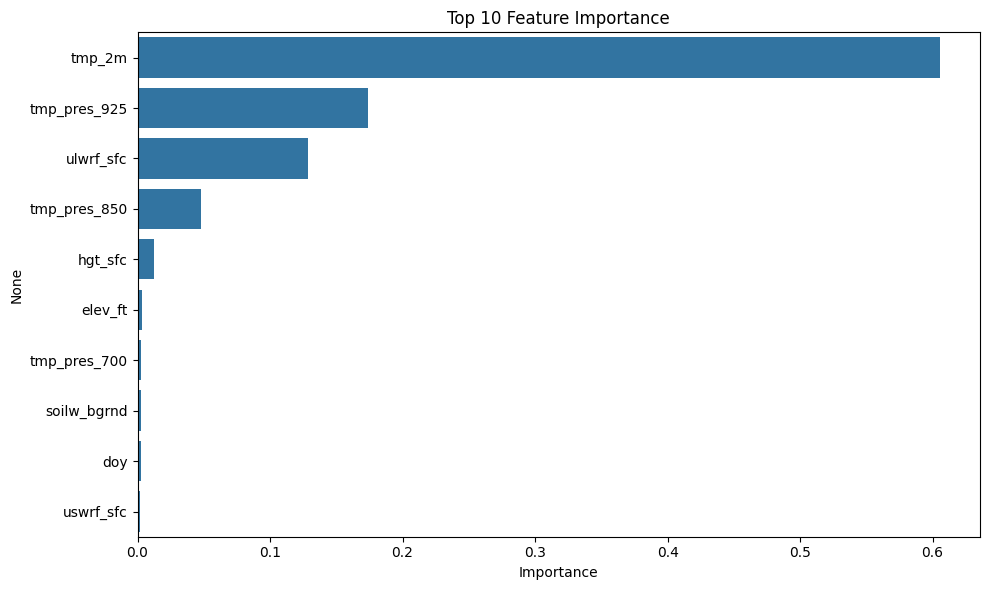
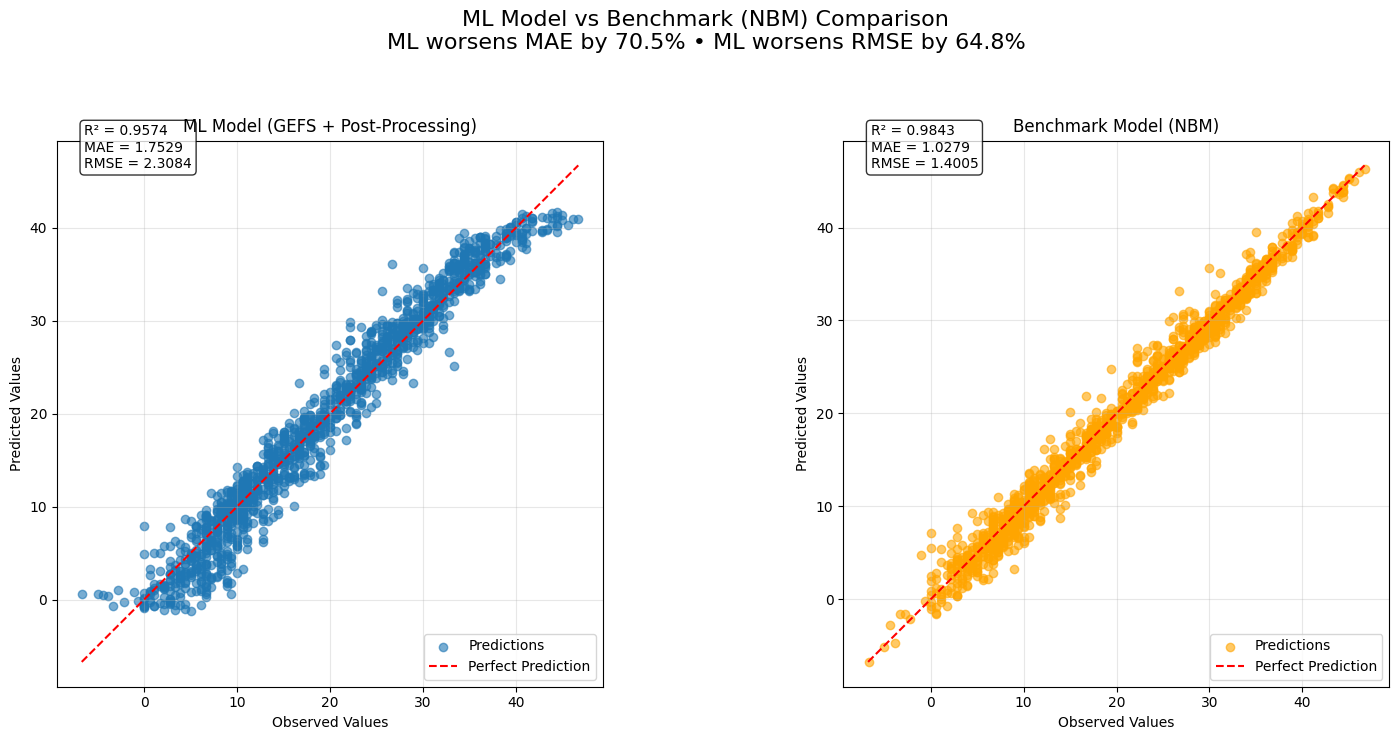
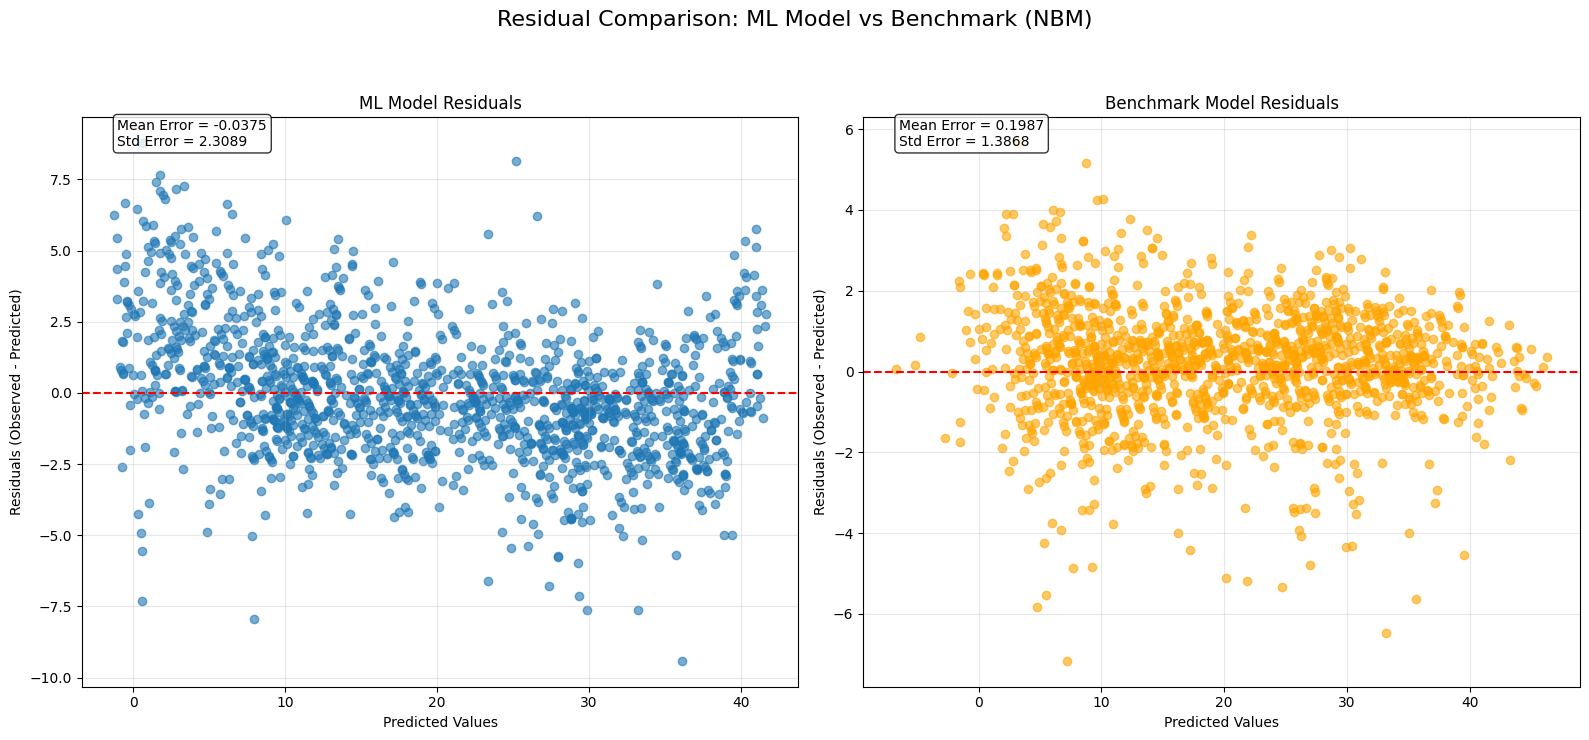
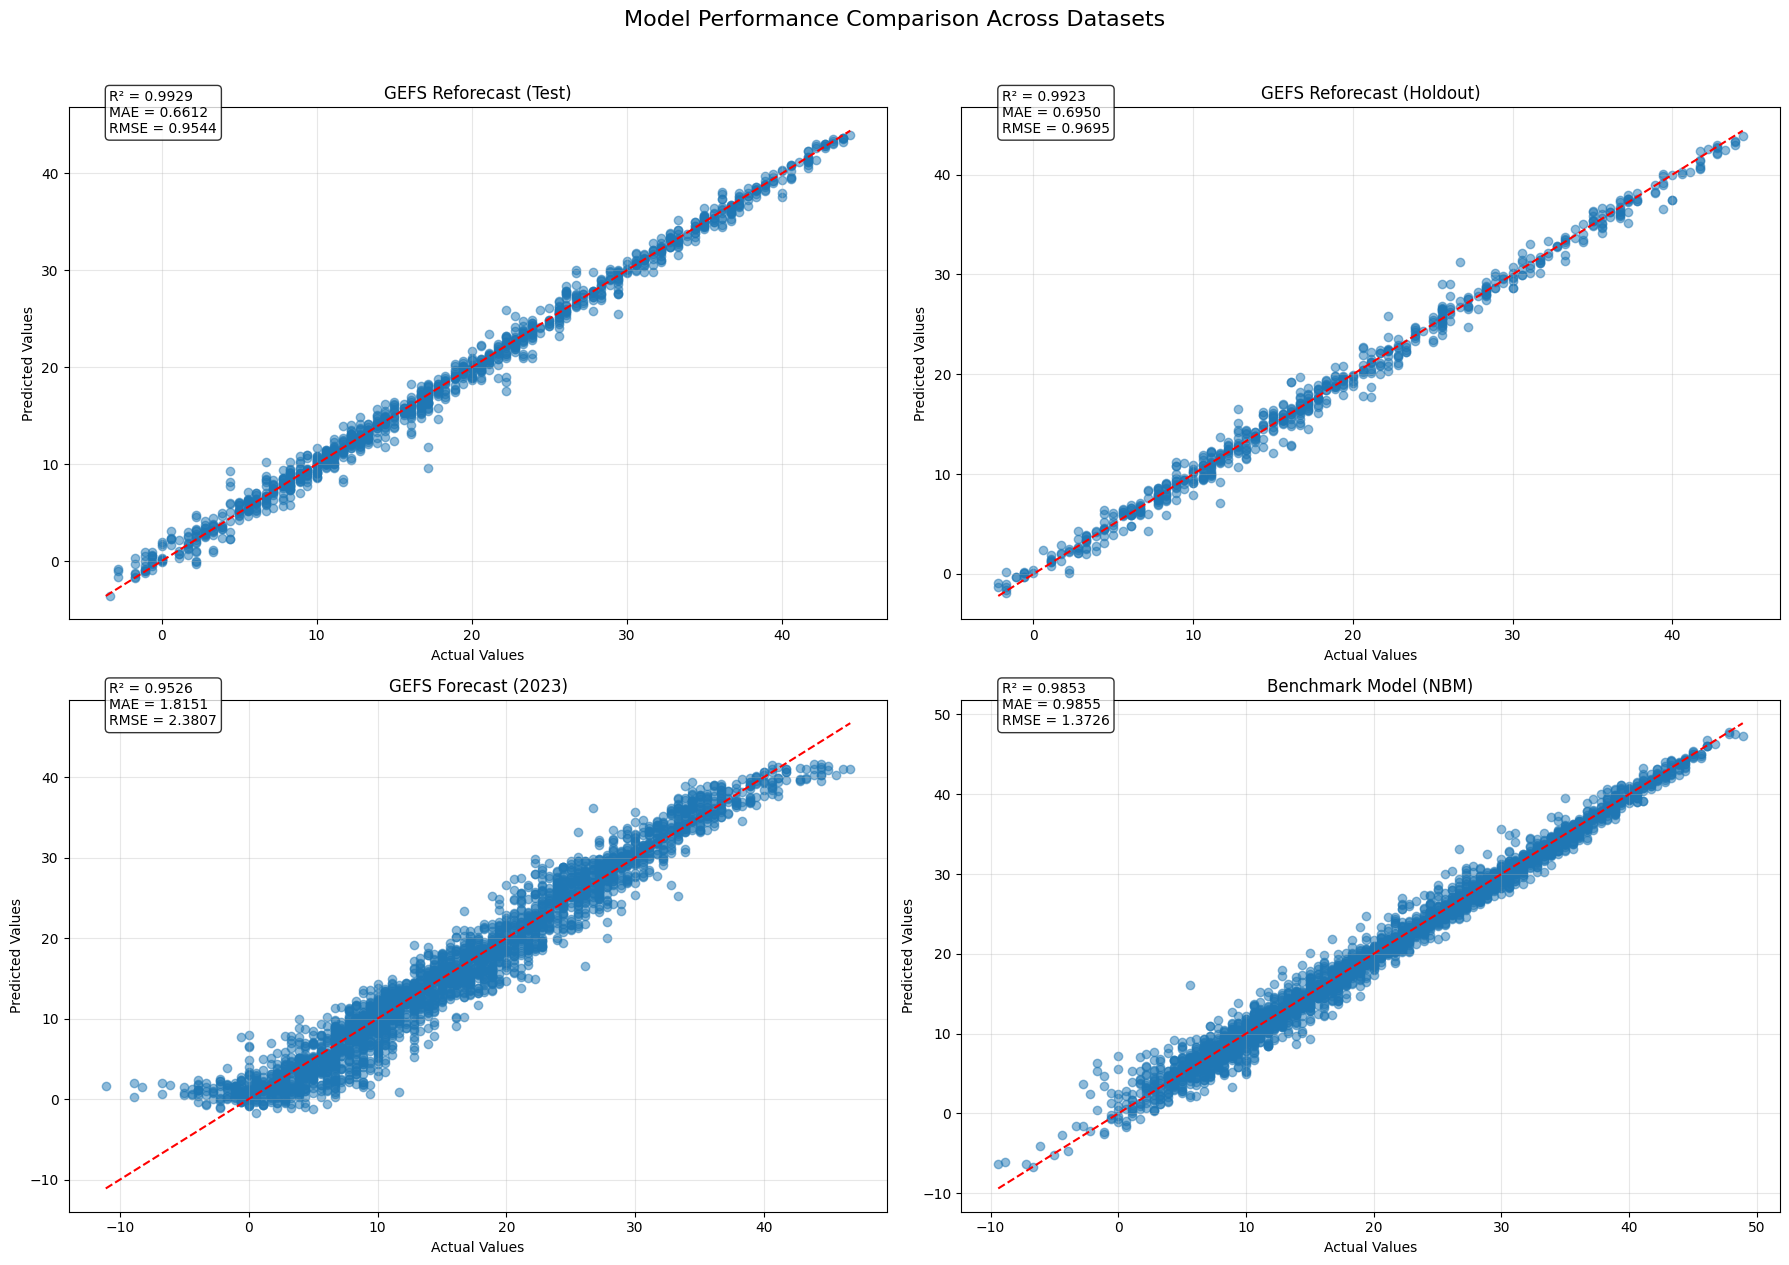
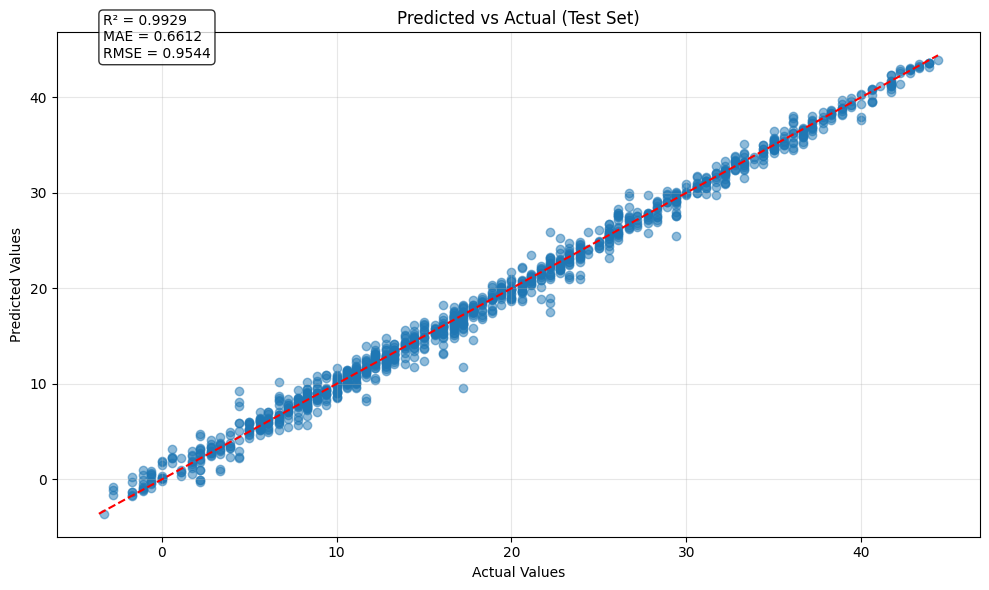
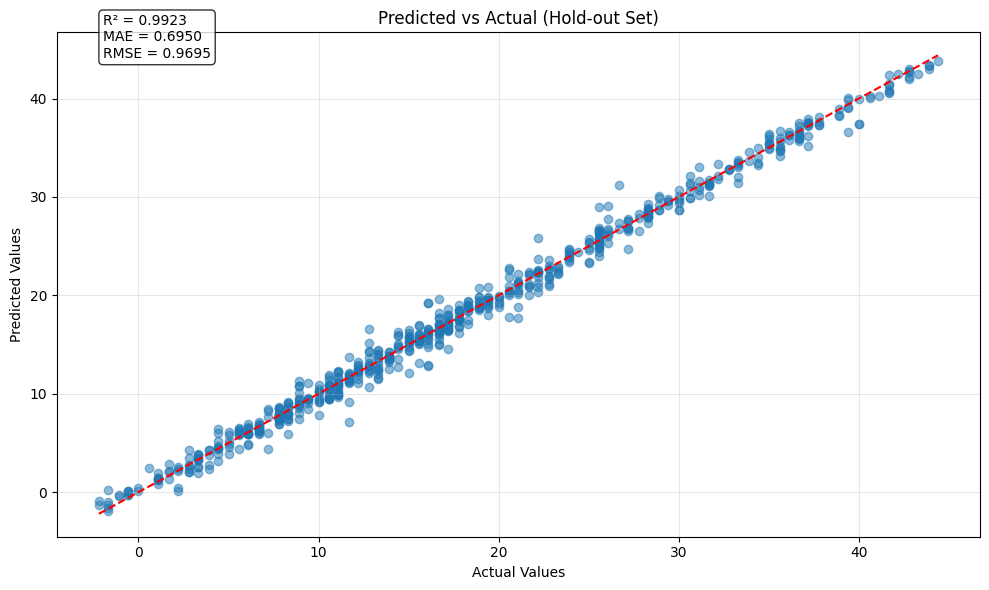
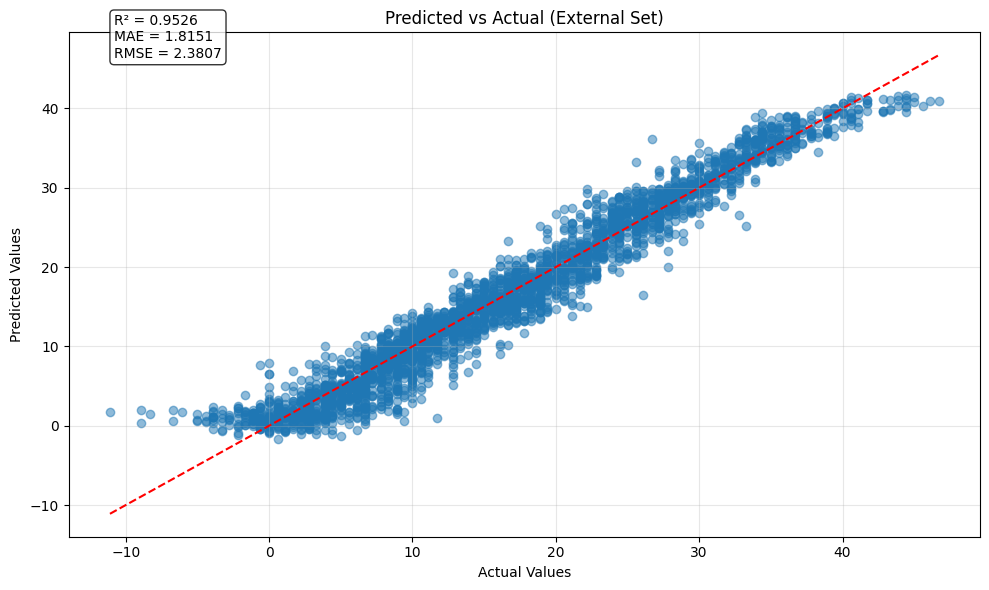
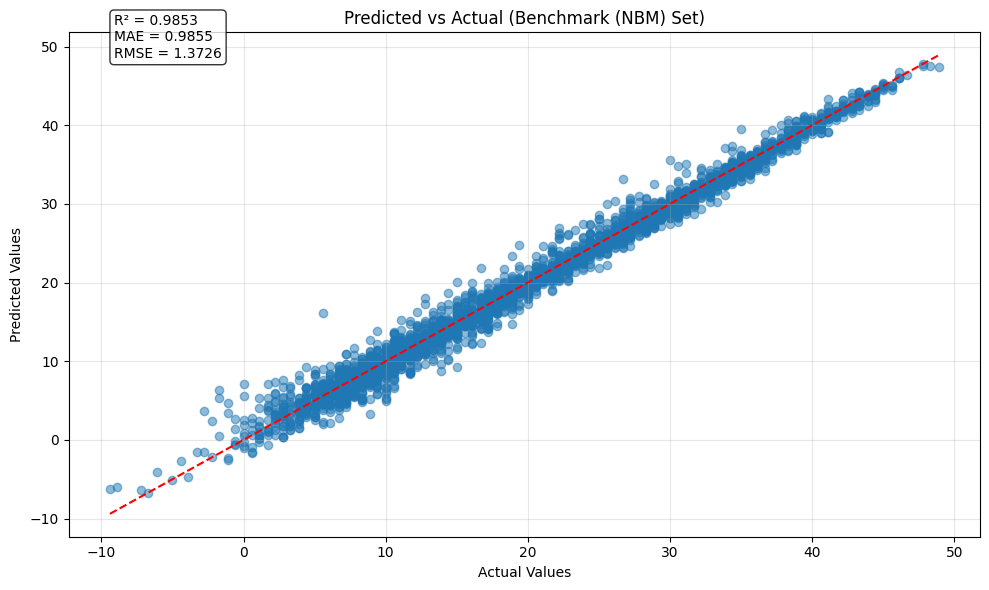
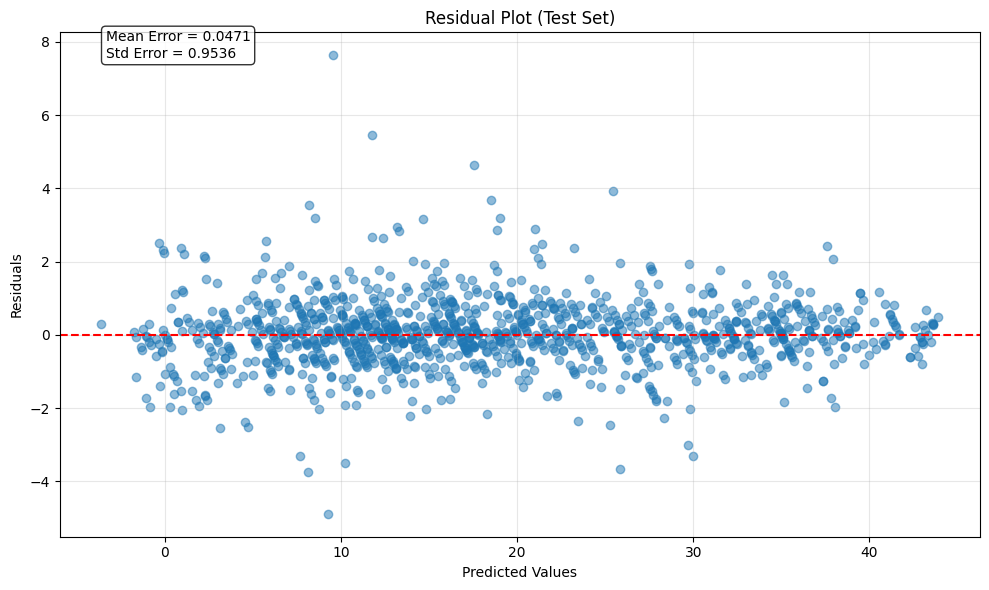
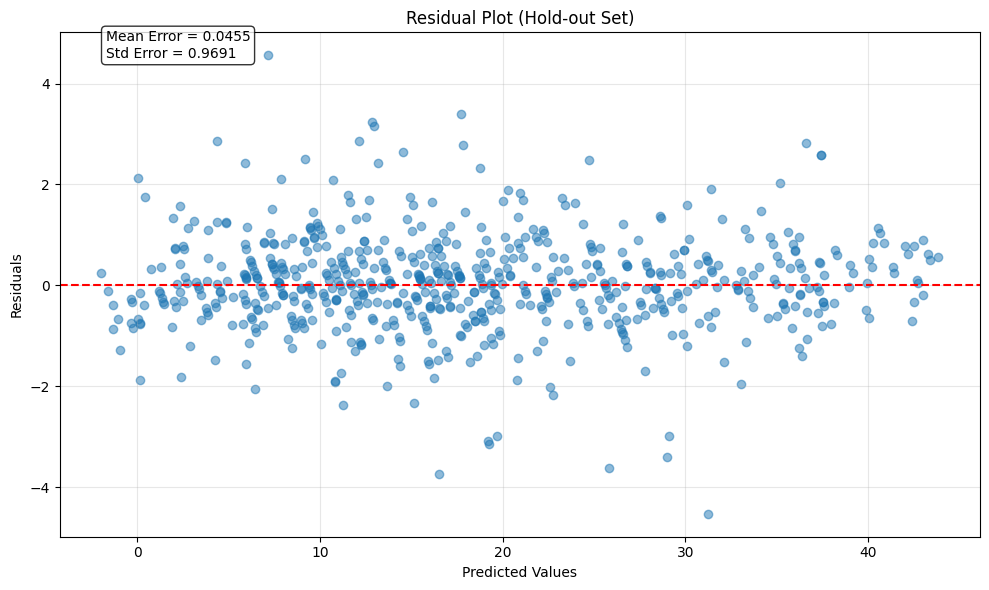
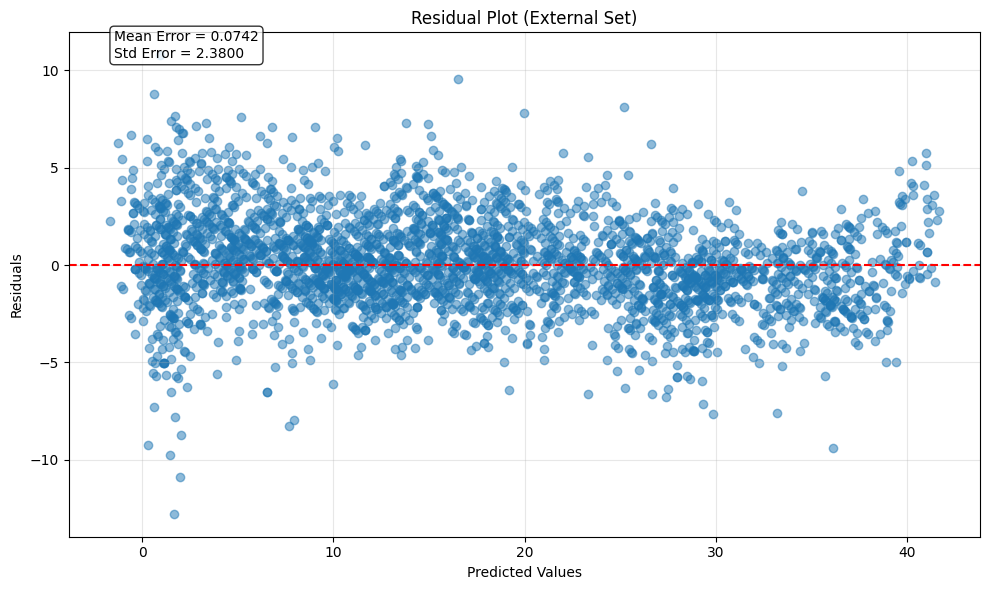
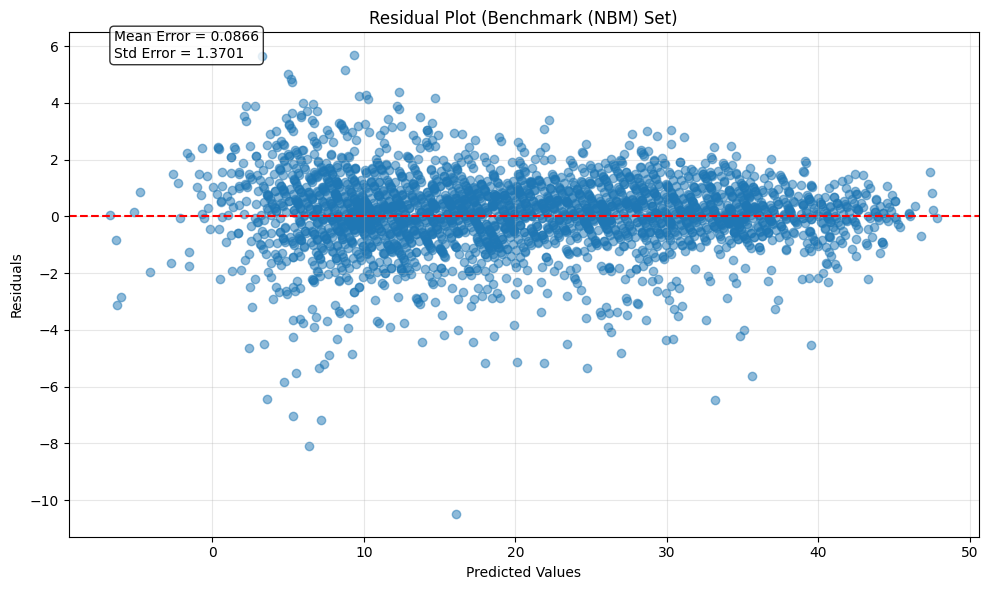
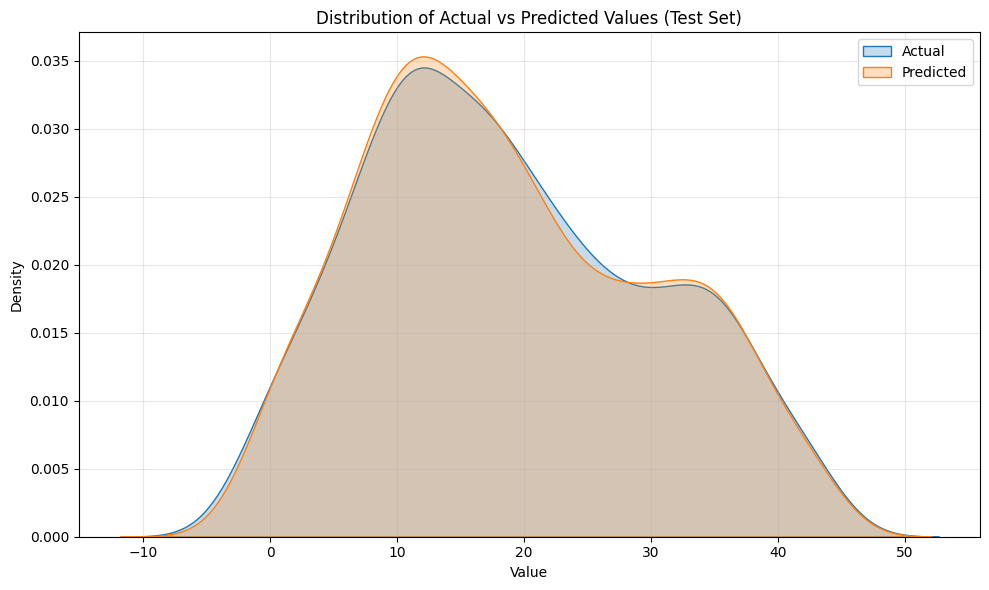
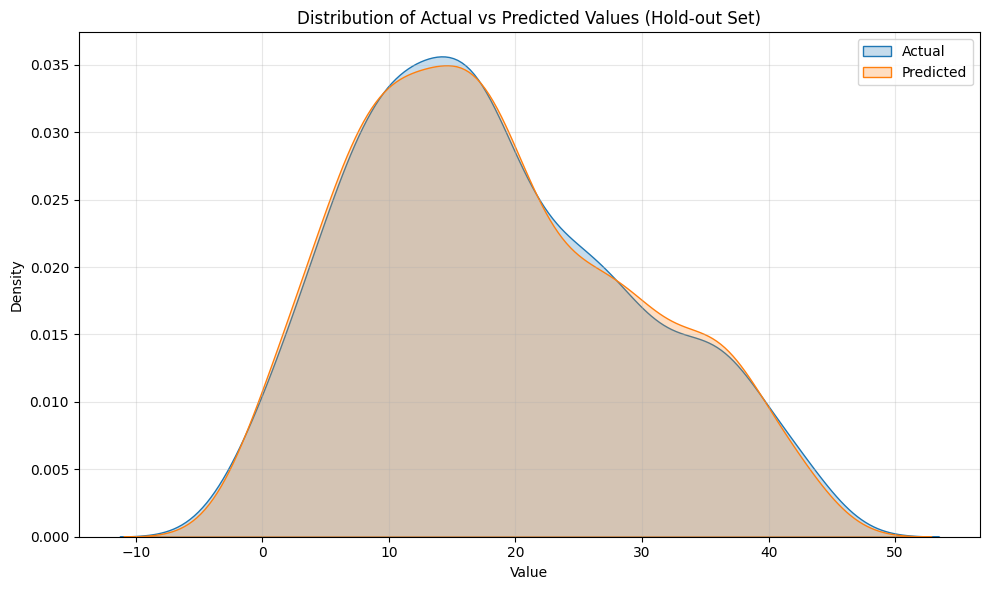
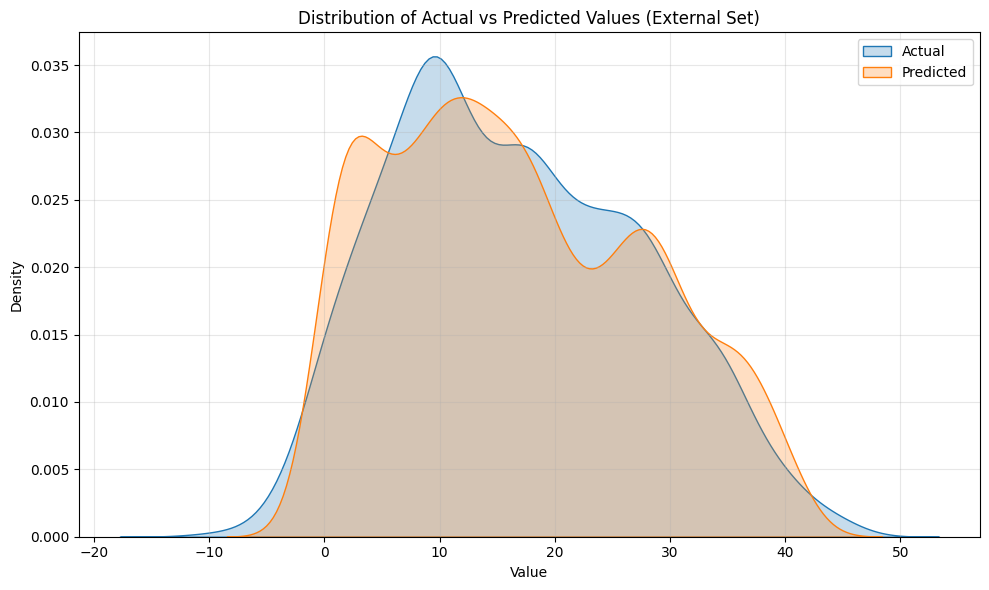
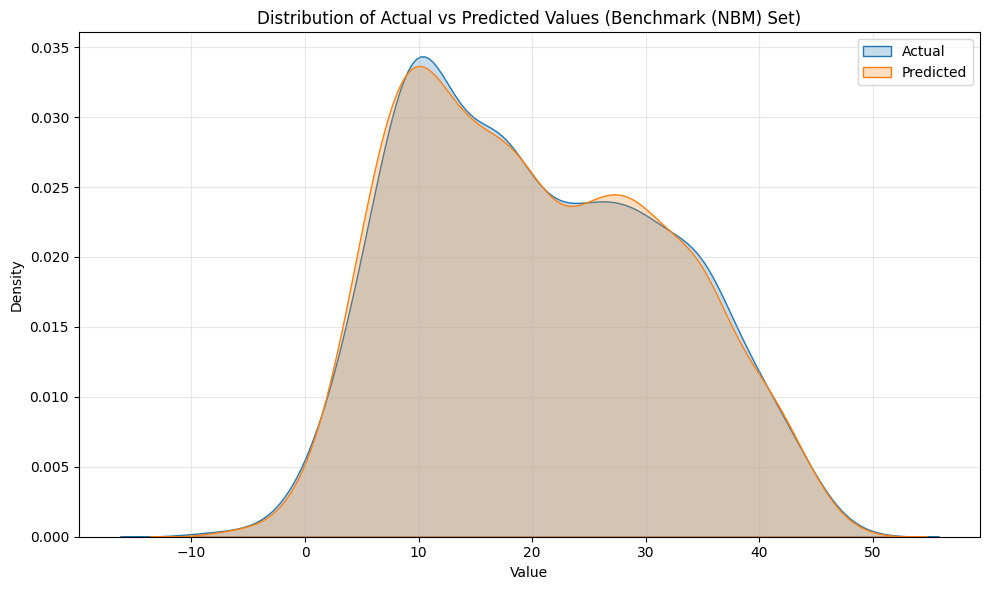
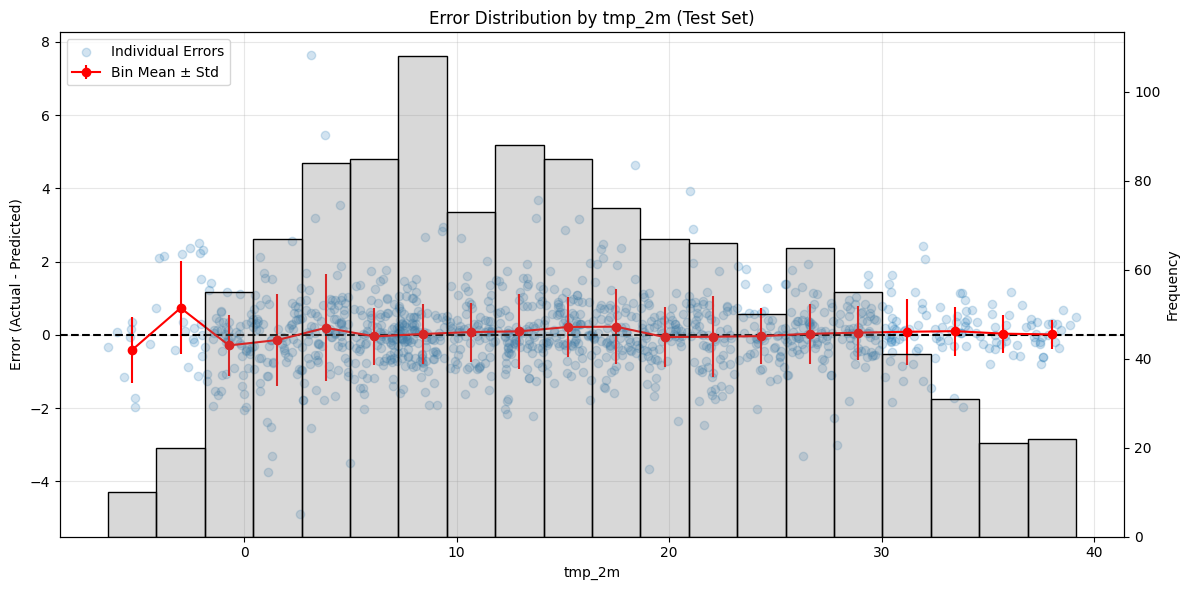
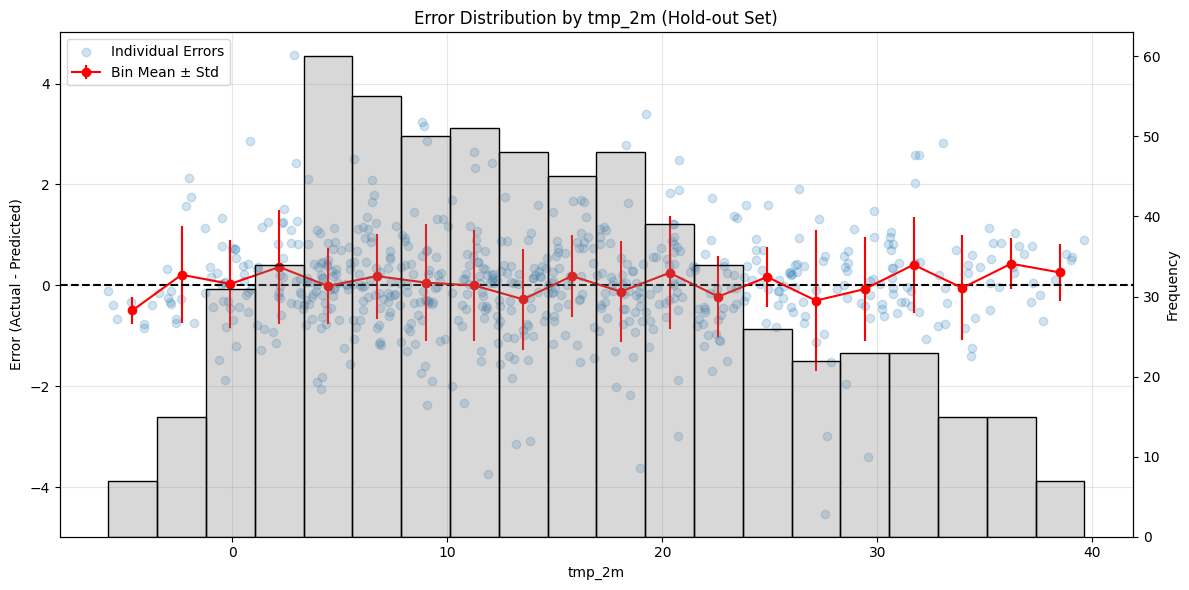
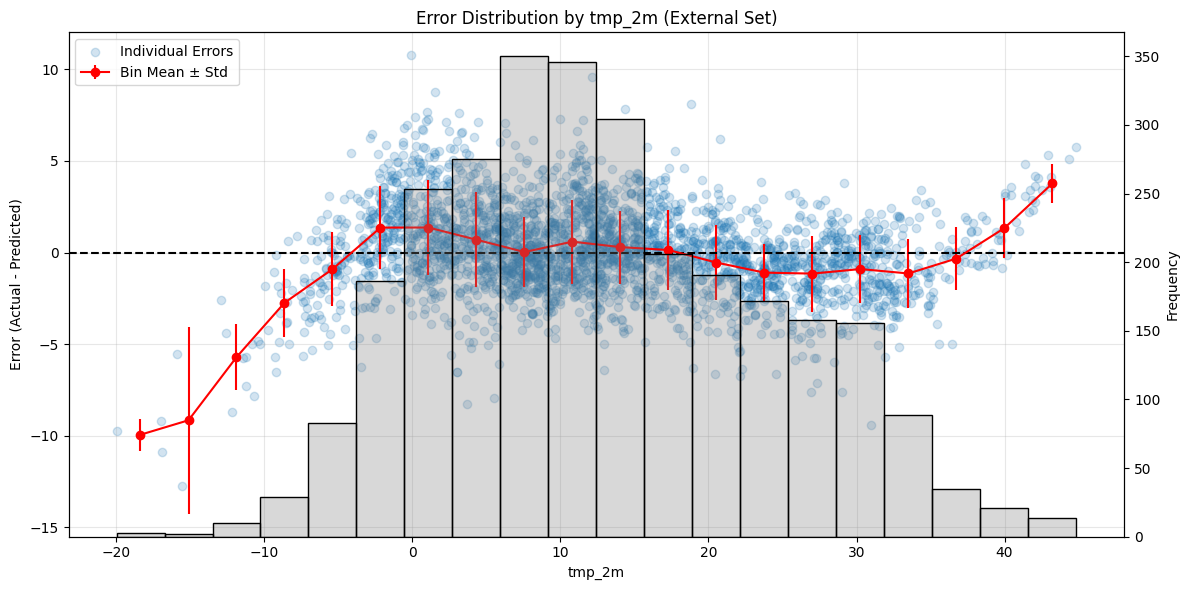


Workflow completed!


In [63]:
# ==============================
# EXECUTE WORKFLOW
# ==============================

CONFIG['model_type'] = 'xgboost'                      # Options: 'linear', 'ridge', 'lasso',
                                                      # 'elasticnet', 'rf', 'gbm', 'xgboost',
                                                      # 'lightgbm'

CONFIG['target_variable'] = 'tmax_obs'                # Options: 'tmax_obs', 'tmin_obs'

# Customize your station IDs and forecast hours here
CONFIG['station_ids'] = ['KBOI', 'KSLC', 'KSEA', 'KLAS']
CONFIG['forecast_hours'] = ['024']

CONFIG['fig_scale'] = 40 # Scales 1-100%, 40% seems to work well in Chrome

# Run the workflow with the defined configuration
trained_pipeline, results, holdout_results, external_results, benchmark_results, feature_importance = run_workflow(CONFIG)

# Save model
# from joblib import dump
# dump(trained_pipeline, f"{CONFIG['model_type']}_model.joblib")

In [65]:
def run_distribution_analysis_from_existing(config, trained_pipeline, results,
                                           holdout_results, external_results,
                                           benchmark_results, feature_importance):
    """
    Perform in-depth analysis of feature distributions using existing model results

    Parameters:
    - config: Configuration dictionary
    - trained_pipeline: Already trained model pipeline
    - results, holdout_results, external_results, benchmark_results: Existing results
    - feature_importance: Pre-computed feature importance
    """
    print("\n" + "="*70)
    print("FEATURE DISTRIBUTION ANALYSIS".center(70))
    print("="*70)

    # Load original data to access features
    print("Loading original training data...")
    original_df = load_data(config)

    # Load external data if needed
    if config['external_data_enabled']:
        print("Loading external data...")
        external_df = load_data(config, config['external_file_pattern'], is_external=True)
    else:
        external_df = None

    # Split into features and target
    X_orig = original_df.drop(columns=[config['target_variable']])
    y_orig = original_df[config['target_variable']]

    # Get external features and target if available
    X_ext = None
    y_ext = None
    if external_df is not None and config['target_variable'] in external_df.columns:
        X_ext = external_df.drop(columns=[config['target_variable']])
        y_ext = external_df[config['target_variable']]

    # Analyze target variable distribution
    print("\n1. Target Variable Distribution Analysis")
    print("-" * 50)
    analyze_target_distribution(y_orig, y_ext, config)

    # Analyze feature distributions
    print("\n2. Feature Distribution Analysis")
    print("-" * 50)
    common_features = analyze_feature_distributions(X_orig, X_ext, config)

    # Analyze scaling and range issues
    print("\n3. Feature Scaling and Range Analysis")
    print("-" * 50)
    scaling_issues = analyze_feature_scaling(X_orig, X_ext, common_features, config)

    # Analyze correlations
    print("\n4. Feature-Target Correlation Analysis")
    print("-" * 50)
    correlation_shifts = analyze_correlation_shifts(X_orig, y_orig, X_ext, y_ext, common_features, config)

    # Analyze prediction errors in relation to features
    print("\n5. Prediction Error Analysis")
    print("-" * 50)
    error_analysis = analyze_prediction_errors(
        results, holdout_results, external_results,
        X_orig, X_ext, scaling_issues,
        config
    )

    # Feature importance vs distribution shift
    print("\n6. Feature Importance vs Distribution Shift Analysis")
    print("-" * 50)
    feature_shift_impact = analyze_importance_vs_shift_existing(
        feature_importance, scaling_issues, correlation_shifts, common_features
    )

    # Generate visualizations
    print("\n7. Generating Comprehensive Visualizations")
    figures = create_distribution_visualizations(
        X_orig, y_orig, X_ext, y_ext,
        scaling_issues, correlation_shifts, feature_shift_impact,
        config
    )

    # Add error analysis visualizations
    error_viz = create_error_analysis_visualizations(
        results, holdout_results, external_results,
        X_orig, X_ext, error_analysis,
        config
    )

    # Combine all visualizations
    figures.update(error_viz)

    # Display visualizations
    if config['use_tabs_for_plots']:
        print("\nDisplaying distribution analysis visualizations in tabs...")
        display_plots_in_tabs(figures, config)

    # Summarize findings and recommendations
    print("\n8. Summary of Findings and Recommendations")
    print("-" * 50)
    summarize_findings(scaling_issues, correlation_shifts, feature_shift_impact, error_analysis, config)

    return {
        'scaling_issues': scaling_issues,
        'correlation_shifts': correlation_shifts,
        'feature_shift_impact': feature_shift_impact,
        'error_analysis': error_analysis
    }

def analyze_target_distribution(y_orig, y_ext, config):
    """Analyze target variable distribution between datasets"""
    target_var = config['target_variable']

    print(f"Target variable: {target_var}")

    # Calculate basic statistics for original data
    print("\nOriginal dataset target statistics:")
    print(f"Count: {len(y_orig)}")
    print(f"Mean: {y_orig.mean():.2f}")
    print(f"Std Dev: {y_orig.std():.2f}")
    print(f"Min: {y_orig.min():.2f}")
    print(f"25%: {y_orig.quantile(0.25):.2f}")
    print(f"Median: {y_orig.median():.2f}")
    print(f"75%: {y_orig.quantile(0.75):.2f}")
    print(f"Max: {y_orig.max():.2f}")

    # Check if external data exists and has the target variable
    if y_ext is not None:
        print("\nExternal dataset target statistics:")
        print(f"Count: {len(y_ext)}")
        print(f"Mean: {y_ext.mean():.2f}")
        print(f"Std Dev: {y_ext.std():.2f}")
        print(f"Min: {y_ext.min():.2f}")
        print(f"25%: {y_ext.quantile(0.25):.2f}")
        print(f"Median: {y_ext.median():.2f}")
        print(f"75%: {y_ext.quantile(0.75):.2f}")
        print(f"Max: {y_ext.max():.2f}")

        # Calculate distribution shift metrics
        mean_diff = abs(y_orig.mean() - y_ext.mean())
        std_diff = abs(y_orig.std() - y_ext.std())
        range_diff = abs((y_orig.max() - y_orig.min()) - (y_ext.max() - y_ext.min()))

        print("\nTarget distribution shift metrics:")
        print(f"Mean absolute difference: {mean_diff:.2f}")
        print(f"Standard deviation difference: {std_diff:.2f}")
        print(f"Range difference: {range_diff:.2f}")

        # Perform Kolmogorov-Smirnov test for distribution similarity
        from scipy import stats
        ks_stat, p_value = stats.ks_2samp(y_orig, y_ext)
        print(f"\nKolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("The target distributions are significantly different (p < 0.05)")
        else:
            print("The target distributions are not significantly different (p >= 0.05)")
    else:
        print("\nExternal dataset target variable not available for comparison")

def analyze_feature_distributions(X_orig, X_ext, config):
    """Analyze feature distributions and identify common features between datasets"""
    print(f"Original dataset features: {X_orig.shape[1]}")

    if X_ext is not None:
        print(f"External dataset features: {X_ext.shape[1]}")

        # Find common features
        orig_features = set(X_orig.columns)
        ext_features = set(X_ext.columns)
        common_features = orig_features.intersection(ext_features)

        print(f"\nCommon features: {len(common_features)}")

        # Features unique to each dataset
        only_orig = orig_features - common_features
        only_ext = ext_features - common_features

        if only_orig:
            print(f"Features only in original data ({len(only_orig)}): {', '.join(sorted(only_orig))}")

        if only_ext:
            print(f"Features only in external data ({len(only_ext)}): {', '.join(sorted(only_ext))}")

        # Select top N most important features to analyze in detail
        n_features = min(10, len(common_features))
        selected_features = list(common_features)[:n_features]

        # Show statistical summary of selected features
        print(f"\nStatistical summary of {n_features} selected features:")
        for feature in selected_features:
            # Calculate basic statistics for both datasets
            orig_mean = X_orig[feature].mean()
            orig_std = X_orig[feature].std()
            ext_mean = X_ext[feature].mean()
            ext_std = X_ext[feature].std()

            # Calculate relative difference
            mean_diff_pct = abs(orig_mean - ext_mean) / max(abs(orig_mean), 1e-10) * 100
            std_diff_pct = abs(orig_std - ext_std) / max(abs(orig_std), 1e-10) * 100

            print(f"\n{feature}:")
            print(f"  Original: mean={orig_mean:.4f}, std={orig_std:.4f}")
            print(f"  External: mean={ext_mean:.4f}, std={ext_std:.4f}")
            print(f"  Difference: mean={mean_diff_pct:.2f}%, std={std_diff_pct:.2f}%")

        return common_features
    else:
        print("External dataset not available for comparison")
        return set(X_orig.columns)

def analyze_feature_scaling(X_orig, X_ext, common_features, config):
    """Analyze feature scaling and range issues between datasets"""
    scaling_issues = {}

    if X_ext is None or len(common_features) == 0:
        print("Cannot analyze feature scaling: external data not available or no common features")
        return scaling_issues

    # Convert common_features to a list if it's a set
    common_features = list(common_features)

    # Select a subset of features for detailed analysis
    n_features = min(20, len(common_features))
    selected_features = common_features[:n_features]

    print(f"Analyzing scaling issues for {n_features} features...")

    for feature in selected_features:
        # Extract feature values from both datasets
        orig_values = X_orig[feature].dropna()
        ext_values = X_ext[feature].dropna()

        if len(orig_values) == 0 or len(ext_values) == 0:
            continue

        # Calculate range statistics
        orig_range = orig_values.max() - orig_values.min()
        ext_range = ext_values.max() - ext_values.min()

        # Calculate the overlap of ranges
        combined_min = min(orig_values.min(), ext_values.min())
        combined_max = max(orig_values.max(), ext_values.max())
        combined_range = combined_max - combined_min

        # Calculate range expansion ratio
        if orig_range > 0:
            range_expansion = combined_range / orig_range
        else:
            range_expansion = float('inf')

        # Calculate normalized statistics
        if orig_range > 0:
            orig_norm_mean = (orig_values.mean() - orig_values.min()) / orig_range
            ext_norm_mean = (ext_values.mean() - orig_values.min()) / orig_range
            norm_mean_diff = abs(orig_norm_mean - ext_norm_mean)
        else:
            norm_mean_diff = float('inf')

        # Calculate if external values fall outside original range
        out_of_range_pct = (
            ((ext_values < orig_values.min()) | (ext_values > orig_values.max())).mean() * 100
            if len(ext_values) > 0 else 0
        )

        # Check if there are significant scaling issues
        has_issue = (
            range_expansion > 1.5 or
            norm_mean_diff > 0.2 or
            out_of_range_pct > 10
        )

        if has_issue:
            scaling_issues[feature] = {
                'range_expansion': range_expansion,
                'norm_mean_diff': norm_mean_diff,
                'out_of_range_pct': out_of_range_pct,
                'orig_range': (orig_values.min(), orig_values.max()),
                'ext_range': (ext_values.min(), ext_values.max()),
                'orig_mean': orig_values.mean(),
                'ext_mean': ext_values.mean(),
                'orig_std': orig_values.std(),
                'ext_std': ext_values.std(),
            }

    # Sort scaling issues by severity (using range_expansion as a proxy)
    scaling_issues = dict(sorted(
        scaling_issues.items(),
        key=lambda x: x[1]['range_expansion'],
        reverse=True
    ))

    # Print summary of scaling issues
    if scaling_issues:
        print(f"\nIdentified {len(scaling_issues)} features with potential scaling issues:")
        for i, (feature, stats) in enumerate(scaling_issues.items(), 1):
            print(f"{i}. {feature}:")
            print(f"   - Range expansion: {stats['range_expansion']:.2f}x")
            print(f"   - Normalized mean difference: {stats['norm_mean_diff']:.4f}")
            print(f"   - External values outside original range: {stats['out_of_range_pct']:.2f}%")
            print(f"   - Original range: [{stats['orig_range'][0]:.4f}, {stats['orig_range'][1]:.4f}]")
            print(f"   - External range: [{stats['ext_range'][0]:.4f}, {stats['ext_range'][1]:.4f}]")

            if i >= 5:  # Limit detailed output to top 5
                remaining = len(scaling_issues) - 5
                print(f"\n...and {remaining} more features with scaling issues")
                break
    else:
        print("No significant scaling issues identified")

    return scaling_issues

def analyze_correlation_shifts(X_orig, y_orig, X_ext, y_ext, common_features, config):
    """Analyze shifts in feature-target correlations between datasets"""
    correlation_shifts = {}

    if X_ext is None or y_ext is None or len(common_features) == 0:
        print("Cannot analyze correlation shifts: external data or target not available")
        return correlation_shifts

    # Convert common_features to a list if it's a set
    common_features = list(common_features)

    print("Analyzing correlation shifts between datasets...")

    # Calculate correlations for original data
    orig_corrs = {}
    for feature in common_features:
        orig_corrs[feature] = X_orig[feature].corr(y_orig)

    # Calculate correlations for external data
    ext_corrs = {}
    for feature in common_features:
        ext_corrs[feature] = X_ext[feature].corr(y_ext)

    # Identify features with significant correlation shifts
    for feature in common_features:
        orig_corr = orig_corrs[feature]
        ext_corr = ext_corrs[feature]

        # Calculate absolute and relative differences
        abs_diff = abs(orig_corr - ext_corr)

        # Check for sign change
        sign_change = (orig_corr * ext_corr) < 0

        # Check if there's a significant correlation shift
        if abs_diff > 0.2 or sign_change:
            correlation_shifts[feature] = {
                'orig_corr': orig_corr,
                'ext_corr': ext_corr,
                'abs_diff': abs_diff,
                'sign_change': sign_change
            }

    # Sort correlation shifts by absolute difference
    correlation_shifts = dict(sorted(
        correlation_shifts.items(),
        key=lambda x: x[1]['abs_diff'],
        reverse=True
    ))

    # Print summary of correlation shifts
    if correlation_shifts:
        print(f"\nIdentified {len(correlation_shifts)} features with significant correlation shifts:")
        for i, (feature, stats) in enumerate(correlation_shifts.items(), 1):
            sign_info = "*** SIGN CHANGE ***" if stats['sign_change'] else ""
            print(f"{i}. {feature}:")
            print(f"   - Original correlation: {stats['orig_corr']:.4f}")
            print(f"   - External correlation: {stats['ext_corr']:.4f}")
            print(f"   - Absolute difference: {stats['abs_diff']:.4f} {sign_info}")

            if i >= 5:  # Limit detailed output to top 5
                remaining = len(correlation_shifts) - 5
                print(f"\n...and {remaining} more features with correlation shifts")
                break
    else:
        print("No significant correlation shifts identified")

    return correlation_shifts

def analyze_prediction_errors(results, holdout_results, external_results, X_orig, X_ext, scaling_issues, config):
    """Analyze prediction errors and their relationship to feature distribution issues"""
    error_analysis = {}

    # Check if we have results for both holdout and external data
    if external_results is None or 'external' not in external_results or 'actual' not in external_results['external']:
        print("Cannot analyze prediction errors: external results not available or missing actual values")
        return error_analysis

    print("Analyzing prediction errors between holdout and external datasets...")

    # Get actual and predicted values for holdout and external sets
    holdout_actual = holdout_results['holdout']['actual']
    holdout_predicted = holdout_results['holdout']['predicted']
    external_actual = external_results['external']['actual']
    external_predicted = external_results['external']['predicted']

    # Calculate errors
    holdout_errors = holdout_actual - holdout_predicted
    external_errors = external_actual - external_predicted

    # Calculate basic error statistics
    error_analysis['holdout'] = {
        'mean_error': holdout_errors.mean(),
        'abs_mean_error': abs(holdout_errors).mean(),
        'std_error': holdout_errors.std(),
        'error_range': (holdout_errors.min(), holdout_errors.max())
    }

    error_analysis['external'] = {
        'mean_error': external_errors.mean(),
        'abs_mean_error': abs(external_errors).mean(),
        'std_error': external_errors.std(),
        'error_range': (external_errors.min(), external_errors.max())
    }

    # Print basic error statistics
    print("\nHoldout error statistics:")
    print(f"Mean error: {error_analysis['holdout']['mean_error']:.4f}")
    print(f"Mean absolute error: {error_analysis['holdout']['abs_mean_error']:.4f}")
    print(f"Error std dev: {error_analysis['holdout']['std_error']:.4f}")
    print(f"Error range: [{error_analysis['holdout']['error_range'][0]:.4f}, "
          f"{error_analysis['holdout']['error_range'][1]:.4f}]")

    print("\nExternal error statistics:")
    print(f"Mean error: {error_analysis['external']['mean_error']:.4f}")
    print(f"Mean absolute error: {error_analysis['external']['abs_mean_error']:.4f}")
    print(f"Error std dev: {error_analysis['external']['std_error']:.4f}")
    print(f"Error range: [{error_analysis['external']['error_range'][0]:.4f}, "
          f"{error_analysis['external']['error_range'][1]:.4f}]")

    # Calculate error difference metrics
    mean_error_diff = abs(error_analysis['holdout']['mean_error'] - error_analysis['external']['mean_error'])
    abs_mean_error_diff = abs(error_analysis['holdout']['abs_mean_error'] - error_analysis['external']['abs_mean_error'])
    std_error_diff = abs(error_analysis['holdout']['std_error'] - error_analysis['external']['std_error'])

    print("\nError difference metrics:")
    print(f"Mean error difference: {mean_error_diff:.4f}")
    print(f"Mean absolute error difference: {abs_mean_error_diff:.4f}")
    print(f"Error std dev difference: {std_error_diff:.4f}")

    # Analyze errors by feature value (for features with scaling issues)
    error_by_feature = {}

    if X_ext is not None and len(scaling_issues) > 0:
        print("\nAnalyzing errors by feature value for problematic features...")

        # Select top features with scaling issues
        top_scaling_features = list(scaling_issues.keys())[:min(5, len(scaling_issues))]

        for feature in top_scaling_features:
            # Check if feature exists in both datasets
            if feature not in X_orig.columns or feature not in X_ext.columns:
                continue

            # Get feature values for holdout and external sets
            # Note: This assumes X_orig contains holdout data, which may not be strictly correct
            # but works for a simplified analysis

            # For a more precise analysis, we'd need access to the exact feature values
            # for the holdout and external sets
            holdout_feature_values = X_orig[feature]
            external_feature_values = X_ext[feature]

            # Calculate correlation between feature value and error
            try:
                # Create Series with matching indices for correlation calculation
                holdout_feature_for_corr = pd.Series(
                    holdout_feature_values.loc[holdout_errors.index].values,
                    index=holdout_errors.index
                )
                holdout_error_corr = holdout_feature_for_corr.corr(holdout_errors)

                external_feature_for_corr = pd.Series(
                    external_feature_values.loc[external_errors.index].values,
                    index=external_errors.index
                )
                external_error_corr = external_feature_for_corr.corr(external_errors)

                error_by_feature[feature] = {
                    'holdout_error_corr': holdout_error_corr,
                    'external_error_corr': external_error_corr,
                    'corr_diff': abs(holdout_error_corr - external_error_corr)
                }
            except:
                # Skip if correlation calculation fails (e.g., due to index mismatch)
                print(f"  Warning: Could not calculate error correlation for {feature}")
                continue

    # Print error by feature summary
    if error_by_feature:
        print("\nFeature-error correlation analysis:")
        for feature, stats in error_by_feature.items():
            print(f"{feature}:")
            print(f"  Holdout error correlation: {stats['holdout_error_corr']:.4f}")
            print(f"  External error correlation: {stats['external_error_corr']:.4f}")
            print(f"  Correlation difference: {stats['corr_diff']:.4f}")

            # Note significant correlation changes
            if stats['corr_diff'] > 0.3:
                print("  *** SIGNIFICANT CORRELATION CHANGE ***")

            # Note sign changes
            if stats['holdout_error_corr'] * stats['external_error_corr'] < 0:
                print("  *** ERROR CORRELATION SIGN CHANGE ***")

    error_analysis['error_by_feature'] = error_by_feature
    return error_analysis

def analyze_importance_vs_shift_existing(feature_importance, scaling_issues, correlation_shifts, common_features):
    """Analyze the relationship between feature importance and distribution shifts using existing results"""
    # Combine feature importance with scaling and correlation information
    feature_shift_impact = {}

    # Normalize feature importance if it's not already
    if feature_importance is not None and feature_importance.sum() > 0:
        feature_importance = feature_importance / feature_importance.sum()

    if feature_importance is None:
        print("Feature importance not available")
        return {}

    for feature in common_features:
        # Skip if feature not in feature_importance
        if feature not in feature_importance.index:
            continue

        has_scaling_issue = feature in scaling_issues
        has_corr_shift = feature in correlation_shifts

        if has_scaling_issue or has_corr_shift:
            importance = feature_importance[feature]

            scaling_info = scaling_issues.get(feature, {})
            correlation_info = correlation_shifts.get(feature, {})

            feature_shift_impact[feature] = {
                'importance': importance,
                'has_scaling_issue': has_scaling_issue,
                'has_corr_shift': has_corr_shift,
                'scaling_info': scaling_info,
                'correlation_info': correlation_info,
                'impact_score': importance * (
                    2 if (has_scaling_issue and has_corr_shift)
                    else 1
                )
            }

    # Sort by impact score
    feature_shift_impact = dict(sorted(
        feature_shift_impact.items(),
        key=lambda x: x[1]['impact_score'],
        reverse=True
    ))

    # Print summary of impact analysis
    if feature_shift_impact:
        print(f"\nTop features by shift impact (combining importance and distribution shifts):")
        for i, (feature, info) in enumerate(feature_shift_impact.items(), 1):
            print(f"{i}. {feature}:")
            print(f"   - Feature importance: {info['importance']:.4f}")
            print(f"   - Has scaling issue: {info['has_scaling_issue']}")
            print(f"   - Has correlation shift: {info['has_corr_shift']}")
            print(f"   - Impact score: {info['impact_score']:.4f}")

            if i >= 5:  # Limit detailed output to top 5
                remaining = len(feature_shift_impact) - 5
                print(f"\n...and {remaining} more features with potential impact")
                break
    else:
        print("No features with both high importance and distribution shifts identified")

    return feature_shift_impact

def create_distribution_visualizations(X_orig, y_orig, X_ext, y_ext,
                                      scaling_issues, correlation_shifts, feature_shift_impact, config):
    """Create visualizations for distribution analysis"""
    figures = {}

    # 1. Target distribution comparison
    if y_ext is not None:
        fig, error = create_target_distribution_plot(y_orig, y_ext, config)
        figures['Target Distribution'] = {'figure': fig, 'error': error}

    # 2. Feature distribution comparisons for top problematic features
    if X_ext is not None:
        top_features_by_impact = list(feature_shift_impact.keys())[:5]

        if top_features_by_impact:
            figs, error = create_feature_distribution_plots(
                X_orig, X_ext, top_features_by_impact, config
            )
            figures['Feature Distributions'] = {'figure': figs, 'error': error}

    # 3. Correlation heatmap comparison
    if X_ext is not None and y_ext is not None:
        fig, error = create_correlation_comparison_plot(
            X_orig, y_orig, X_ext, y_ext, correlation_shifts, config
        )
        figures['Correlation Comparison'] = {'figure': fig, 'error': error}

    # 4. Feature importance vs shift impact plot
    if feature_shift_impact:
        fig, error = create_importance_vs_shift_plot(feature_shift_impact, config)
        figures['Importance vs Shift'] = {'figure': fig, 'error': error}

    # 5. QQ plots for features with scaling issues
    if X_ext is not None and scaling_issues:
        top_scaling_features = list(scaling_issues.keys())[:5]
        figs, error = create_qq_plots(X_orig, X_ext, top_scaling_features, config)
        figures['QQ Plots'] = {'figure': figs, 'error': error}

    return figures

def create_error_analysis_visualizations(results, holdout_results, external_results,
                                        X_orig, X_ext, error_analysis, config):
    """Create visualizations for error analysis"""
    figures = {}

    # 1. Error distribution comparison
    fig, error = create_error_distribution_plot(holdout_results, external_results, config)
    figures['Error Distributions'] = {'figure': fig, 'error': error}

    # 2. Error vs feature plots for problematic features
    if 'error_by_feature' in error_analysis and error_analysis['error_by_feature']:
        top_error_features = list(error_analysis['error_by_feature'].keys())[:3]

        if top_error_features:
            figs, error = create_error_by_feature_plots(
                holdout_results, external_results,
                X_orig, X_ext, top_error_features,
                config
            )
            figures['Error by Feature'] = {'figure': figs, 'error': error}

    # 3. Prediction vs actual plots with error highlighted
    fig, error = create_prediction_comparison_plot(holdout_results, external_results, config)
    figures['Prediction Comparison'] = {'figure': fig, 'error': error}

    return figures

def create_target_distribution_plot(y_orig, y_ext, config):
    """Create target distribution comparison plot"""
    try:
        fig, ax = plt.subplots(figsize=(12, 6))

        sns.histplot(y_orig, bins=30, alpha=0.5, label='Original Data', ax=ax, kde=True)
        sns.histplot(y_ext, bins=30, alpha=0.5, label='External Data', ax=ax, kde=True)

        ax.set_title(f'Distribution of Target Variable: {config["target_variable"]}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistical information
        orig_stats = f"Original: mean={y_orig.mean():.2f}, std={y_orig.std():.2f}"
        ext_stats = f"External: mean={y_ext.mean():.2f}, std={y_ext.std():.2f}"

        ax.annotate(f'{orig_stats}\n{ext_stats}',
                   xy=(0.05, 0.95), xycoords='axes fraction',
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                   va='top')

        fig.tight_layout()
        return fig, None
    except Exception as e:
        return None, f"Error creating target distribution plot: {str(e)}"

def create_feature_distribution_plots(X_orig, X_ext, features, config):
    """Create distribution plots for multiple features"""
    try:
        figs = []

        for feature in features:
            fig, ax = plt.subplots(figsize=(12, 6))

            # Get feature data
            orig_values = X_orig[feature].dropna()
            ext_values = X_ext[feature].dropna()

            # Plot distributions
            sns.histplot(orig_values, bins=30, alpha=0.5, label='Original Data', ax=ax, kde=True)
            sns.histplot(ext_values, bins=30, alpha=0.5, label='External Data', ax=ax, kde=True)

            ax.set_title(f'Distribution of Feature: {feature}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend()
            ax.grid(True, alpha=0.3)

            # Add statistical information
            orig_stats = f"Original: mean={orig_values.mean():.2f}, std={orig_values.std():.2f}"
            ext_stats = f"External: mean={ext_values.mean():.2f}, std={ext_values.std():.2f}"

            ax.annotate(f'{orig_stats}\n{ext_stats}',
                       xy=(0.05, 0.95), xycoords='axes fraction',
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                       va='top')

            fig.tight_layout()
            figs.append(fig)

        return figs, None
    except Exception as e:
        return None, f"Error creating feature distribution plots: {str(e)}"

def create_correlation_comparison_plot(X_orig, y_orig, X_ext, y_ext, correlation_shifts, config):
    """Create correlation comparison visualization"""
    try:
        # Select top features by correlation shift
        top_features = list(correlation_shifts.keys())[:10]

        if not top_features:
            return None, "No significant correlation shifts to visualize"

        fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data for plotting
        features = []
        orig_corrs = []
        ext_corrs = []

        for feature in top_features:
            features.append(feature)
            orig_corrs.append(correlation_shifts[feature]['orig_corr'])
            ext_corrs.append(correlation_shifts[feature]['ext_corr'])

        # Convert to DataFrames for easier plotting
        plot_data = pd.DataFrame({
            'Feature': features + features,
            'Correlation': orig_corrs + ext_corrs,
            'Dataset': ['Original'] * len(features) + ['External'] * len(features)
        })

        # Create grouped bar chart
        sns.barplot(
            data=plot_data, x='Feature', y='Correlation', hue='Dataset',
            palette=['blue', 'orange'], ax=ax
        )

        ax.set_title('Feature-Target Correlation Comparison')
        ax.set_xlabel('Feature')
        ax.set_ylabel('Correlation with Target')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3)

        # Rotate x-axis labels for readability
        plt.xticks(rotation=45, ha='right')

        fig.tight_layout()
        return fig, None
    except Exception as e:
        return None, f"Error creating correlation comparison plot: {str(e)}"

def create_importance_vs_shift_plot(feature_shift_impact, config):
    """Create plot showing feature importance vs distribution shift impact"""
    try:
        fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data for plotting
        features = []
        importances = []
        has_scaling = []
        has_corr_shift = []

        for feature, info in feature_shift_impact.items():
            features.append(feature)
            importances.append(info['importance'])
            has_scaling.append(info['has_scaling_issue'])
            has_corr_shift.append(info['has_corr_shift'])

        # Create DataFrame
        plot_data = pd.DataFrame({
            'Feature': features,
            'Importance': importances,
            'Has Scaling Issue': has_scaling,
            'Has Correlation Shift': has_corr_shift
        })

        # Sort by importance
        plot_data = plot_data.sort_values('Importance', ascending=False).head(15)

        # Create bar chart
        bars = ax.barh(plot_data['Feature'], plot_data['Importance'])

        # Color bars based on issues
        for i, (_, row) in enumerate(plot_data.iterrows()):
            if row['Has Scaling Issue'] and row['Has Correlation Shift']:
                bars[i].set_color('red')
            elif row['Has Scaling Issue']:
                bars[i].set_color('orange')
            elif row['Has Correlation Shift']:
                bars[i].set_color('purple')
            else:
                bars[i].set_color('blue')

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', label='Both Issues'),
            Patch(facecolor='orange', label='Scaling Issue'),
            Patch(facecolor='purple', label='Correlation Shift'),
            Patch(facecolor='blue', label='No Issues')
        ]
        ax.legend(handles=legend_elements, loc='lower right')

        ax.set_title('Feature Importance and Distribution Issues')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')
        ax.grid(True, alpha=0.3)

        fig.tight_layout()
        return fig, None
    except Exception as e:
        return None, f"Error creating importance vs shift plot: {str(e)}"

def create_qq_plots(X_orig, X_ext, features, config):
    """Create QQ plots for features with scaling issues"""
    try:
        from scipy import stats

        figs = []

        for feature in features:
            fig, ax = plt.subplots(figsize=(10, 10))

            # Get feature data
            orig_values = X_orig[feature].dropna()
            ext_values = X_ext[feature].dropna()

            # If too many data points, sample a subset
            if len(orig_values) > 1000:
                orig_values = orig_values.sample(1000, random_state=42)
            if len(ext_values) > 1000:
                ext_values = ext_values.sample(1000, random_state=42)

            # Create QQ plot
            stats.probplot(orig_values, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot for {feature} (Original Data)')
            fig.tight_layout()
            figs.append(fig)

            fig, ax = plt.subplots(figsize=(10, 10))
            stats.probplot(ext_values, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot for {feature} (External Data)')
            fig.tight_layout()
            figs.append(fig)

        return figs, None
    except Exception as e:
        return None, f"Error creating QQ plots: {str(e)}"

def create_error_distribution_plot(holdout_results, external_results, config):
    """Create error distribution comparison plot"""
    try:
        fig, ax = plt.subplots(figsize=(12, 6))

        # Get errors
        holdout_actual = holdout_results['holdout']['actual']
        holdout_predicted = holdout_results['holdout']['predicted']
        external_actual = external_results['external']['actual']
        external_predicted = external_results['external']['predicted']

        holdout_errors = holdout_actual - holdout_predicted
        external_errors = external_actual - external_predicted

        # Plot error distributions
        sns.histplot(holdout_errors, bins=30, alpha=0.5, label='Holdout Errors', ax=ax, kde=True)
        sns.histplot(external_errors, bins=30, alpha=0.5, label='External Errors', ax=ax, kde=True)

        ax.set_title('Distribution of Prediction Errors')
        ax.set_xlabel('Error (Actual - Predicted)')
        ax.set_ylabel('Frequency')
        ax.axvline(x=0, color='black', linestyle='--')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistical information
        holdout_stats = f"Holdout: mean={holdout_errors.mean():.2f}, std={holdout_errors.std():.2f}"
        external_stats = f"External: mean={external_errors.mean():.2f}, std={external_errors.std():.2f}"

        ax.annotate(f'{holdout_stats}\n{external_stats}',
                   xy=(0.05, 0.95), xycoords='axes fraction',
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                   va='top')

        fig.tight_layout()
        return fig, None
    except Exception as e:
        return None, f"Error creating error distribution plot: {str(e)}"

def create_error_by_feature_plots(holdout_results, external_results, X_orig, X_ext, features, config):
    """Create plots showing errors by feature value"""
    try:
        figs = []

        # Get errors
        holdout_actual = holdout_results['holdout']['actual']
        holdout_predicted = holdout_results['holdout']['predicted']
        external_actual = external_results['external']['actual']
        external_predicted = external_results['external']['predicted']

        holdout_errors = holdout_actual - holdout_predicted
        external_errors = external_actual - external_predicted

        for feature in features:
            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

            # Plot holdout errors vs feature value
            try:
                # Get feature values for holdout set
                # Note: This is an approximation as we don't have direct access to holdout feature values
                holdout_feature = X_orig[feature].loc[holdout_errors.index]

                # Create scatter plot
                ax1.scatter(holdout_feature, holdout_errors, alpha=0.5)
                ax1.set_title(f'Holdout Errors vs {feature}')
                ax1.set_xlabel(feature)
                ax1.set_ylabel('Error (Actual - Predicted)')
                ax1.axhline(y=0, color='red', linestyle='--')
                ax1.grid(True, alpha=0.3)

                # Add trend line
                from scipy import stats
                slope, intercept, r_value, p_value, std_err = stats.linregress(holdout_feature, holdout_errors)
                x_vals = np.array([min(holdout_feature), max(holdout_feature)])
                y_vals = intercept + slope * x_vals
                ax1.plot(x_vals, y_vals, 'r-', label=f'Trend (r={r_value:.2f})')
                ax1.legend()
            except Exception as e:
                ax1.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=ax1.transAxes)

            # Plot external errors vs feature value
            try:
                # Get feature values for external set
                external_feature = X_ext[feature].loc[external_errors.index]

                # Create scatter plot
                ax2.scatter(external_feature, external_errors, alpha=0.5, color='orange')
                ax2.set_title(f'External Errors vs {feature}')
                ax2.set_xlabel(feature)
                ax2.set_ylabel('Error (Actual - Predicted)')
                ax2.axhline(y=0, color='red', linestyle='--')
                ax2.grid(True, alpha=0.3)

                # Add trend line
                slope, intercept, r_value, p_value, std_err = stats.linregress(external_feature, external_errors)
                x_vals = np.array([min(external_feature), max(external_feature)])
                y_vals = intercept + slope * x_vals
                ax2.plot(x_vals, y_vals, 'r-', label=f'Trend (r={r_value:.2f})')
                ax2.legend()
            except Exception as e:
                ax2.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=ax2.transAxes)

            fig.tight_layout()
            figs.append(fig)

        return figs, None
    except Exception as e:
        return None, f"Error creating error by feature plots: {str(e)}"

def create_prediction_comparison_plot(holdout_results, external_results, config):
    """Create comparison of predictions between holdout and external data"""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        # Get values
        holdout_actual = holdout_results['holdout']['actual']
        holdout_predicted = holdout_results['holdout']['predicted']
        external_actual = external_results['external']['actual']
        external_predicted = external_results['external']['predicted']

        # Calculate metrics
        holdout_r2 = holdout_results['holdout']['r2']
        holdout_mae = holdout_results['holdout']['mae']
        holdout_rmse = holdout_results['holdout']['rmse']

        external_r2 = external_results['external']['r2']
        external_mae = external_results['external']['mae']
        external_rmse = external_results['external']['rmse']

        # Holdout scatter plot
        ax1.scatter(holdout_actual, holdout_predicted, alpha=0.5)
        min_val = min(holdout_actual.min(), holdout_predicted.min())
        max_val = max(holdout_actual.max(), holdout_predicted.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax1.set_title('Holdout Predictions')
        ax1.set_xlabel('Actual Values')
        ax1.set_ylabel('Predicted Values')
        ax1.grid(True, alpha=0.3)
        ax1.annotate(f'R² = {holdout_r2:.4f}\nMAE = {holdout_mae:.4f}\nRMSE = {holdout_rmse:.4f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        # External scatter plot
        ax2.scatter(external_actual, external_predicted, alpha=0.5, color='orange')
        min_val = min(external_actual.min(), external_predicted.min())
        max_val = max(external_actual.max(), external_predicted.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax2.set_title('External Predictions')
        ax2.set_xlabel('Actual Values')
        ax2.set_ylabel('Predicted Values')
        ax2.grid(True, alpha=0.3)
        ax2.annotate(f'R² = {external_r2:.4f}\nMAE = {external_mae:.4f}\nRMSE = {external_rmse:.4f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        # Ensure both plots have the same scale for easier comparison
        x_min = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
        x_max = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

        ax1.set_xlim([x_min, x_max])
        ax1.set_ylim([y_min, y_max])
        ax2.set_xlim([x_min, x_max])
        ax2.set_ylim([y_min, y_max])

        fig.tight_layout()
        return fig, None
    except Exception as e:
        return None, f"Error creating prediction comparison plot: {str(e)}"

def summarize_findings(scaling_issues, correlation_shifts, feature_shift_impact, error_analysis, config):
    """Summarize findings and provide recommendations"""
    print("SUMMARY OF FINDINGS:")

    # Get counts of issues
    scaling_issue_count = len(scaling_issues)
    correlation_shift_count = len(correlation_shifts)

    # Count features with both issues
    both_issues_count = sum(
        1 for feature in feature_shift_impact
        if feature_shift_impact[feature]['has_scaling_issue']
        and feature_shift_impact[feature]['has_corr_shift']
    )

    print(f"\n1. Found {scaling_issue_count} features with scaling issues")
    print(f"2. Found {correlation_shift_count} features with correlation shifts")
    print(f"3. Found {both_issues_count} features with both scaling and correlation issues")

    # Error analysis summary
    if error_analysis:
        holdout_mean_error = error_analysis.get('holdout', {}).get('mean_error')
        external_mean_error = error_analysis.get('external', {}).get('mean_error')

        if holdout_mean_error is not None and external_mean_error is not None:
            print(f"\n4. Error analysis:")
            print(f"   - Holdout mean error: {holdout_mean_error:.4f}")
            print(f"   - External mean error: {external_mean_error:.4f}")

            error_diff = abs(holdout_mean_error - external_mean_error)
            if error_diff > 0.5:
                print(f"   - Large difference in mean errors: {error_diff:.4f}")
                if external_mean_error > holdout_mean_error:
                    print("   - Model systematically UNDERESTIMATES in external data")
                else:
                    print("   - Model systematically OVERESTIMATES in external data")

    # Top problematic features
    if feature_shift_impact:
        top_features = list(feature_shift_impact.keys())[:5]
        print("\n5. Top problematic features (by impact score):")
        for i, feature in enumerate(top_features, 1):
            info = feature_shift_impact[feature]
            issues = []
            if info['has_scaling_issue']:
                issues.append("scaling")
            if info['has_corr_shift']:
                issues.append("correlation")

            issue_str = " and ".join(issues)
            print(f"   {i}. {feature} - {issue_str} issues, importance: {info['importance']:.4f}")

    # Provide recommendations
    print("\nRECOMMENDATIONS:")

    if scaling_issue_count > 0:
        print("\n1. Scaling and Range Issues:")
        print("   - Apply StandardScaler or RobustScaler to features in both training and inference")
        print("   - Check for unit mismatches between training and external data")
        print("   - Consider trimming or capping outliers consistently")

        # Specific features to focus on
        top_scaling_features = list(scaling_issues.keys())[:3]
        if top_scaling_features:
            print("   - Priority features to fix:")
            for feature in top_scaling_features:
                print(f"     * {feature}")

    if correlation_shift_count > 0:
        print("\n2. Correlation Shift Issues:")
        print("   - Review feature engineering steps for both datasets")
        print("   - Consider feature selection to focus on stable features")
        print("   - Test with simpler models that may generalize better")

        # Specific features to focus on
        top_corr_features = list(correlation_shifts.keys())[:3]
        if top_corr_features:
            print("   - Priority features to examine:")
            for feature in top_corr_features:
                print(f"     * {feature}")

    if both_issues_count > 0:
        print("\n3. For Features with Both Issues:")
        print("   - Prioritize fixing these features as they have highest impact")
        print("   - Consider creating composite/derived features")

        # Specific features with both issues
        both_issues_features = [
            feature for feature in feature_shift_impact
            if feature_shift_impact[feature]['has_scaling_issue']
            and feature_shift_impact[feature]['has_corr_shift']
        ][:3]

        if both_issues_features:
            print("   - Critical features to address:")
            for feature in both_issues_features:
                print(f"     * {feature}")

    print("\n4. General Recommendations:")
    print("   - Test standardization/normalization applied to both training and external data")
    print("   - Implement automated feature selection to focus on stable features")
    print("   - Consider ensemble approaches that combine multiple models")
    print("   - Periodically retrain the model with new data")
    print("   - Implement monitoring for data drift in production")

    # Model-specific recommendations
    model_type = config['model_type'].lower()
    print(f"\n5. {model_type.upper()} Model Specific Recommendations:")

    if model_type in ['xgboost', 'lightgbm', 'rf']:
        print("   - Try reducing model complexity (max_depth, n_estimators)")
        print("   - Increase regularization parameters")
        print("   - Experiment with larger min_samples_leaf/min_data_in_leaf")
    elif model_type in ['linear', 'ridge', 'lasso', 'elasticnet']:
        print("   - Try stronger regularization")
        print("   - Consider polynomial features")
        print("   - Feature interactions may help capture non-linear relationships")


                    FEATURE DISTRIBUTION ANALYSIS                     
Loading original training data...
Loading GEFS Reforecast data for 4 station(s) and 1 forecast hour(s)...
Multi-station mode: 'hgt_sfc' and 'elev_ft' will be included as features
  Loading file: /content/KBOI_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSLC_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSEA_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KLAS_2000_2009_f024.csv
  Successfully loaded 18265 rows
Combined dataset: 73060 rows, 49 columns
Added day-of-year feature
Applied perturbation averaging
Excluded 18 variables: ['sid', 'state', 'init_datetime', 'fcst_hour', 'perturbation', 'tmin_obs', 'tmin_2m', 'tmax_2m', 'spfh_pres_850', 'spfh_pres_700', 'gflux_sfc', 'cape_sfc', 'hgt_ceiling', 'vflx_sfc', 'gust_sfc', 'cin_sfc', 'uflx_sfc', 'spfh_2m']
Dropped 1 non-numeric columns: ['station_id']
Filtered to 30 numeric co


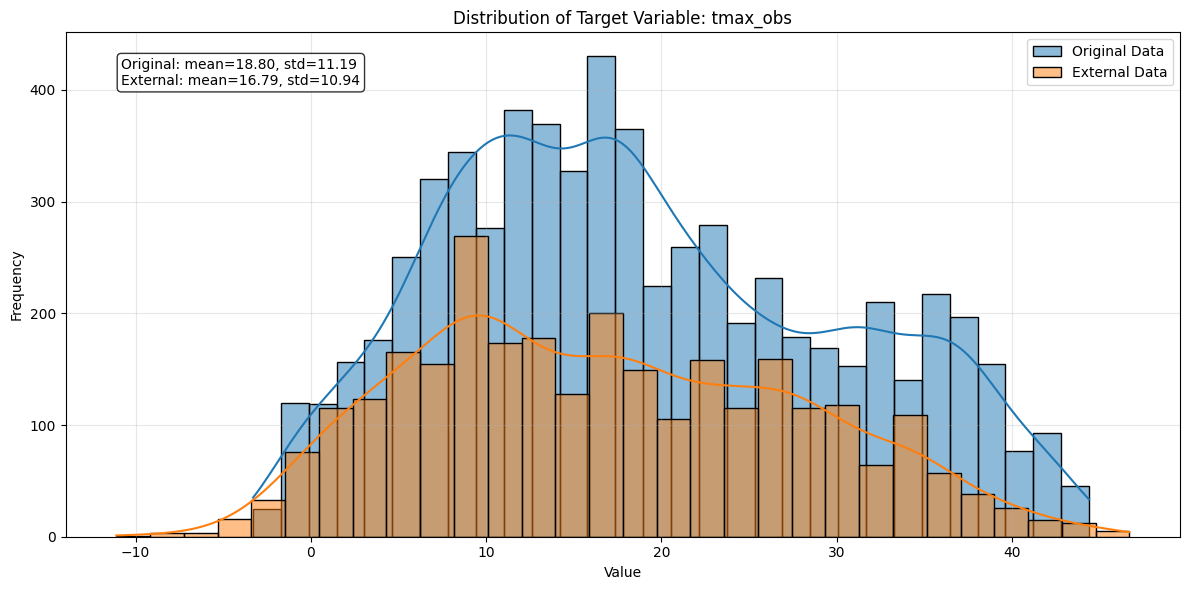
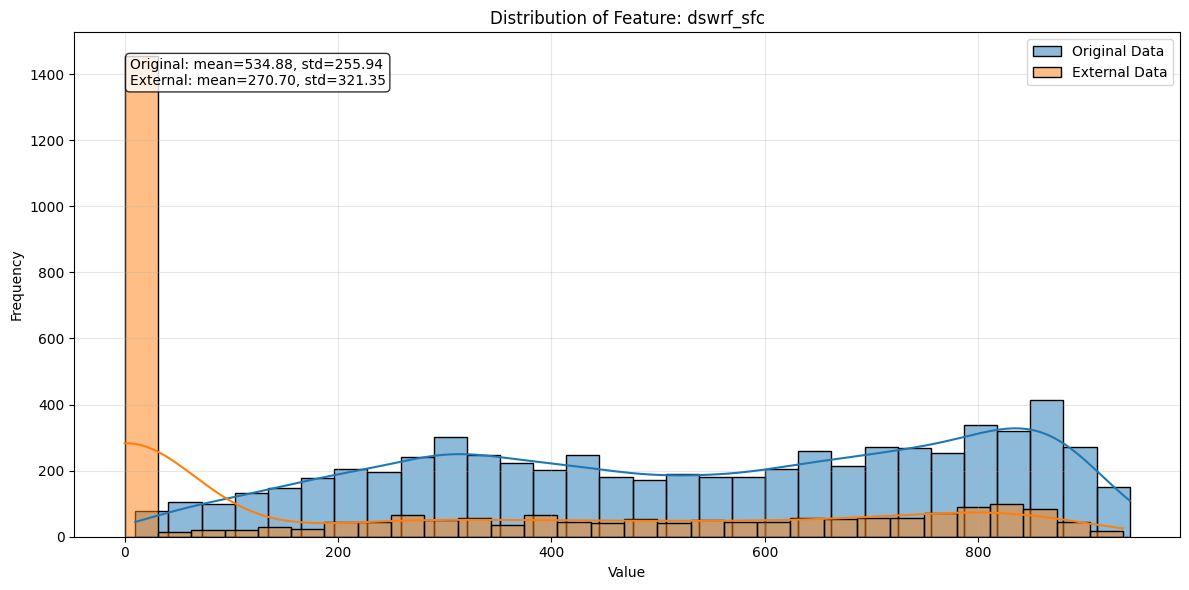
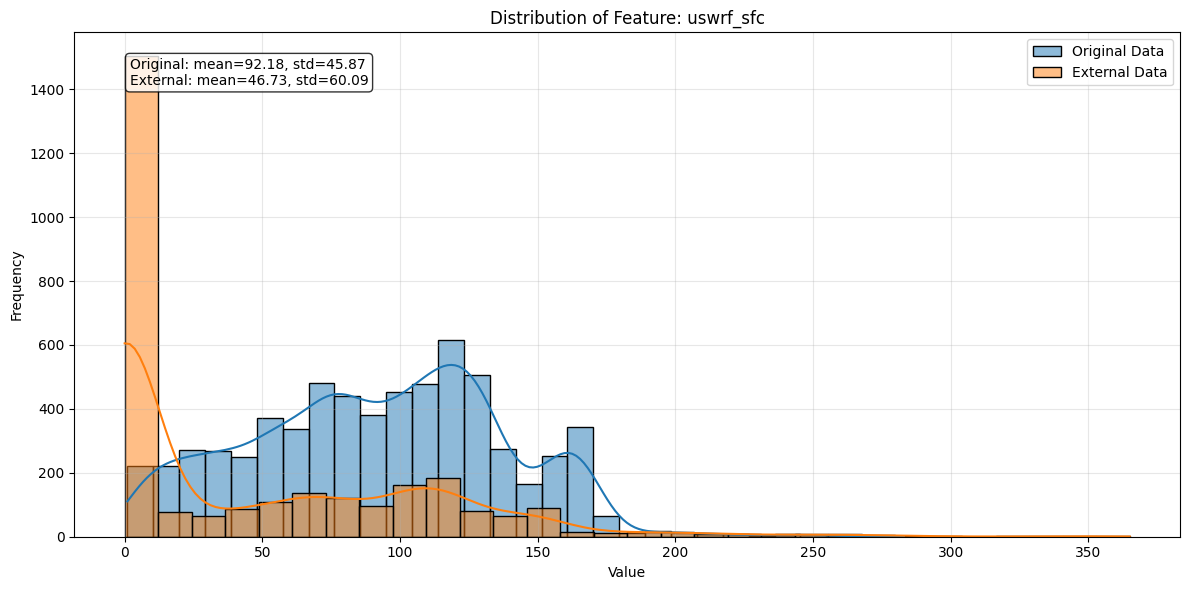
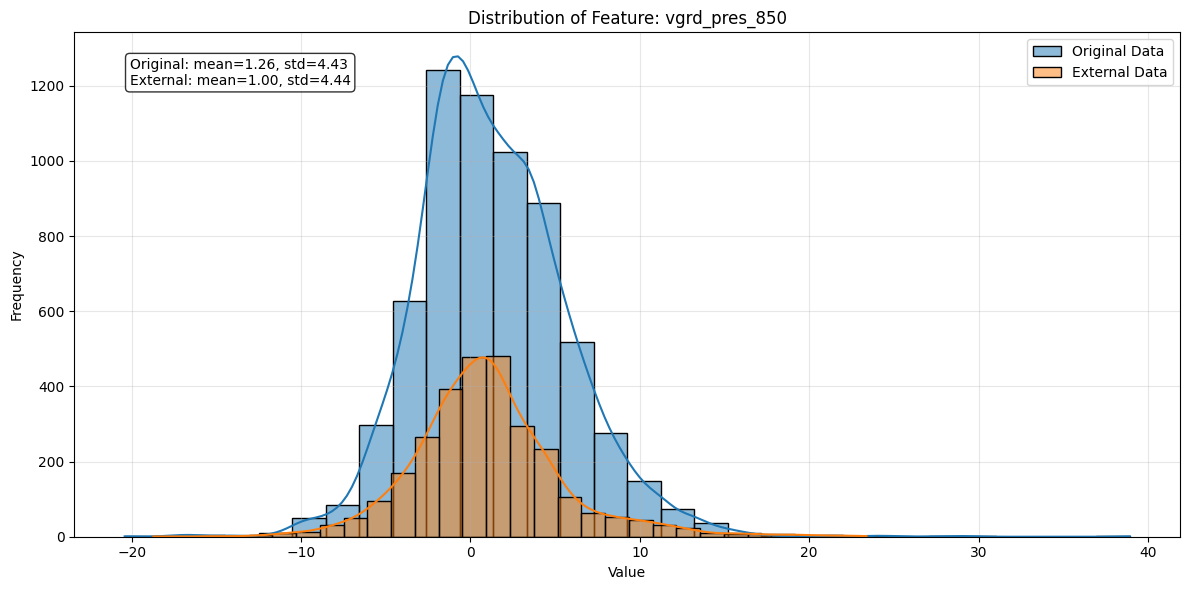
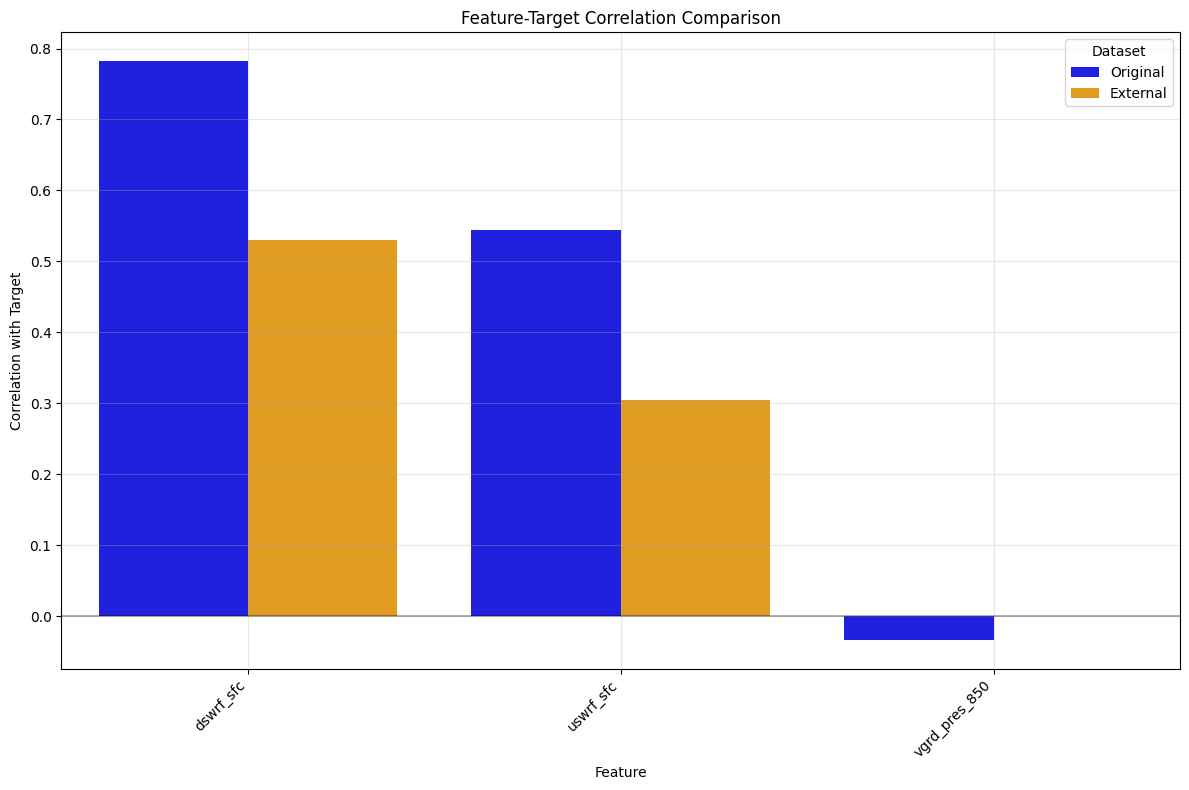
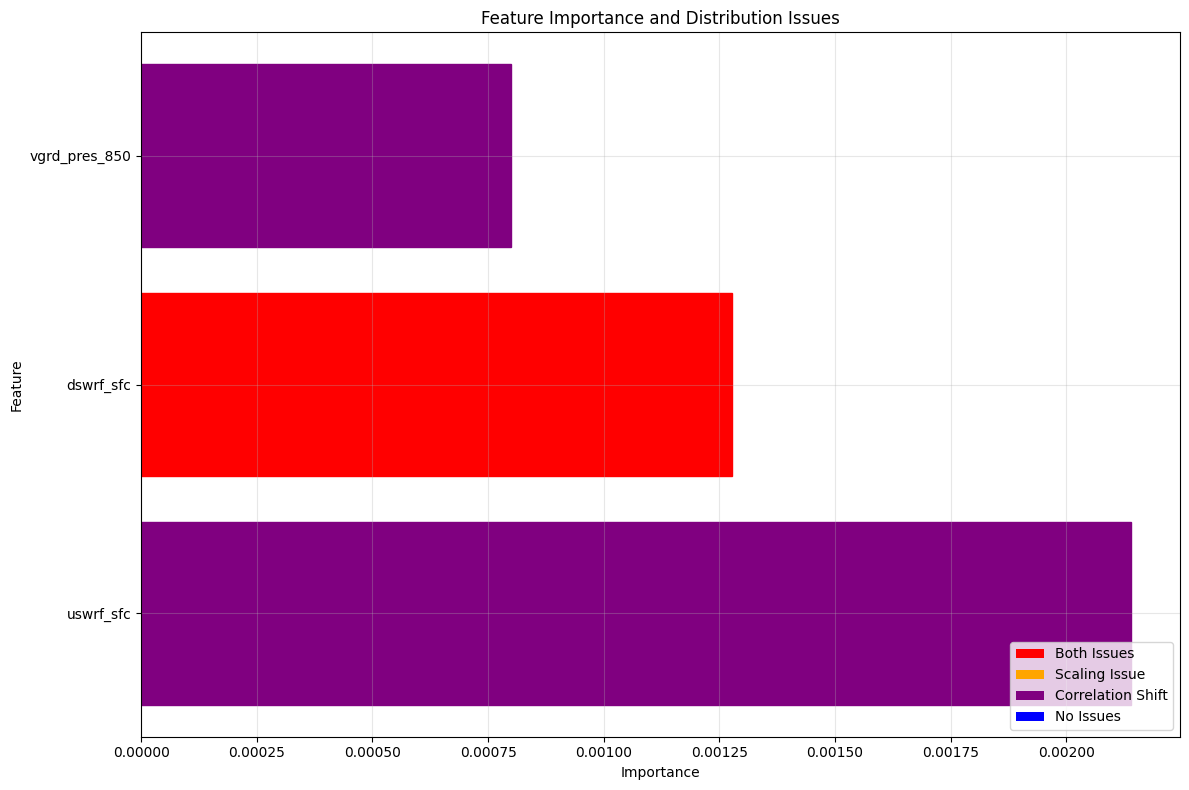
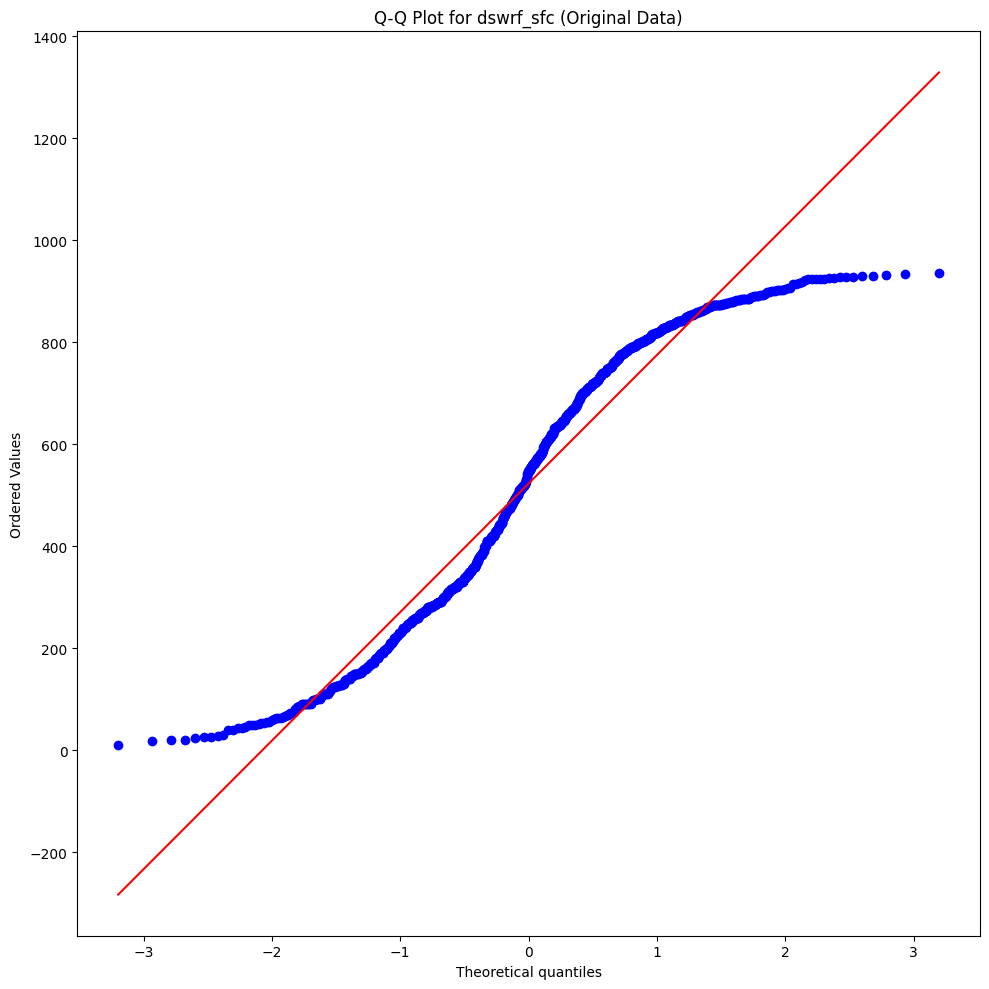
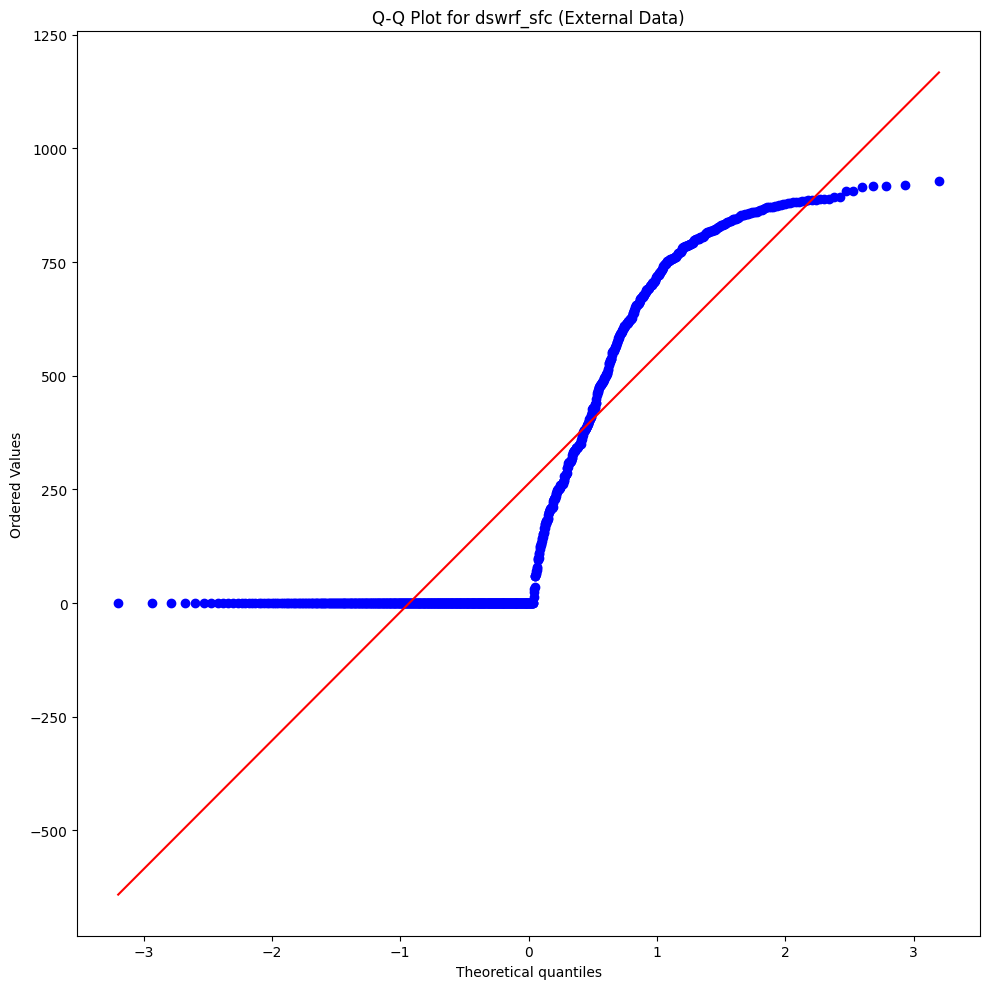
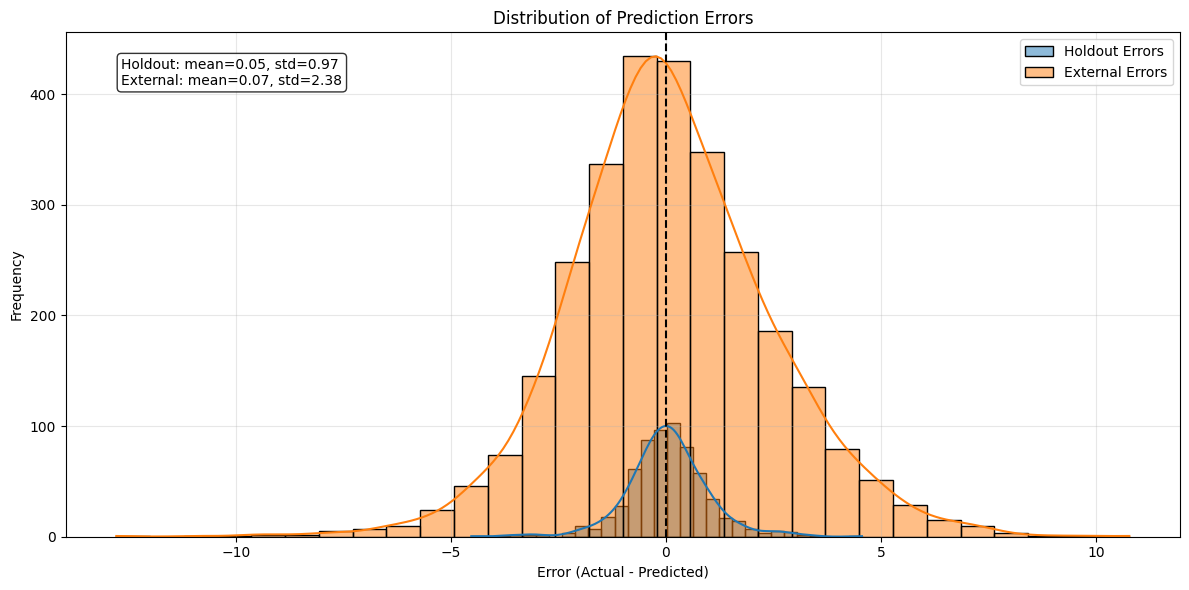
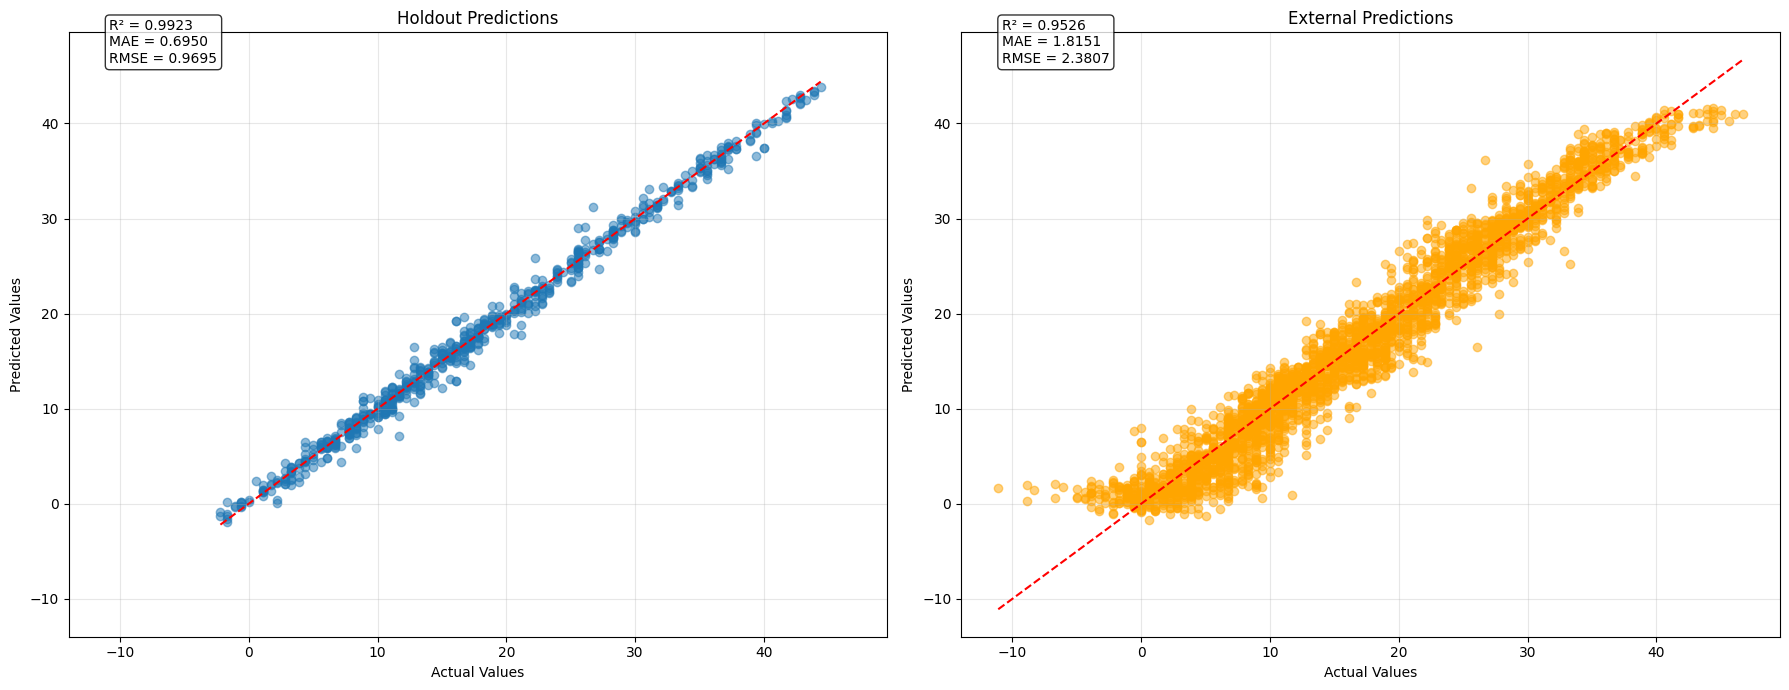


8. Summary of Findings and Recommendations
--------------------------------------------------
SUMMARY OF FINDINGS:

1. Found 1 features with scaling issues
2. Found 3 features with correlation shifts
3. Found 1 features with both scaling and correlation issues

4. Error analysis:
   - Holdout mean error: 0.0455
   - External mean error: 0.0742

5. Top problematic features (by impact score):
   1. dswrf_sfc - scaling and correlation issues, importance: 0.0013
   2. uswrf_sfc - correlation issues, importance: 0.0021
   3. vgrd_pres_850 - correlation issues, importance: 0.0008

RECOMMENDATIONS:

1. Scaling and Range Issues:
   - Apply StandardScaler or RobustScaler to features in both training and inference
   - Check for unit mismatches between training and external data
   - Consider trimming or capping outliers consistently
   - Priority features to fix:
     * dswrf_sfc

2. Correlation Shift Issues:
   - Review feature engineering steps for both datasets
   - Consider feature selecti

In [66]:
# Run distribution analysis using existing results
analysis_results = run_distribution_analysis_from_existing(
    CONFIG,
    trained_pipeline,
    results,
    holdout_results,
    external_results,
    benchmark_results,
    feature_importance
)